In [1]:
suppressMessages(library(ArchR))
library(parallel)
library(rhdf5)
library(SingleCellExperiment)
#library(SeuratDisk)
#library(Seurat)
library(cowplot)
library(here)

#devtools::install_github("GreenleafLab/chromVARmotifs")
library(chromVAR)

ss <- function(x, pattern, slot = 1, ...) { sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)

addArchRGenome("mm10")

here() starts at /projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq



No methods found in package ‘IRanges’ for request: ‘score’ when loading ‘TFBSTools’

Setting default genome to Mm10.



# load data

In [2]:
PROJDIR=here('data/tidy_data/ArchRProjects/')
projNeuron = loadArchRProject(file.path(PROJDIR,'Mouse_scATAC_DorsalHorn_neuron2_wDeviations'), showLogo = FALSE) #neuron2 is correct proj

getAvailableMatrices(ArchRProj = projNeuron)

### Drop midVen for this analysis
projNeuron = projNeuron[projNeuron$FINAL_GROUP_LABEL != 'midVen']

Successfully loaded ArchRProject!



[1] "GeneIntegrationMatrix"  "GeneIntegrationMatrix1" "GeneScoreMatrix"       
[4] "MotifMatrix"            "PeakMatrix"             "TileMatrix"

In [3]:
#getCellColData(projNeuron)
table(projNeuron$FINAL_GROUP_LABEL)


  GABA1 GABA2_1 GABA2_2   GABA3 GABA4_1 GABA4_2   GABA5   GLUT1  GLUT10  GLUT11 
   1078      64    1545     376     967     795    1320    1092     431      39 
  GLUT2   GLUT3   GLUT4   GLUT5   GLUT6   GLUT7   GLUT8   GLUT9 
   2452    1945     341     992    2195    2283    1157       1 

# check if mef2c is in motif matrix

In [30]:
motif_matrix = getMatrixFromProject(projNeuron, useMatrix = "MotifMatrix")

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-392c539b355d2-Date-2023-12-18_Time-12-47-33.log
If there is an issue, please report to github with logFile!

2023-12-18 12:48:28 : Organizing colData, 0.916 mins elapsed.

2023-12-18 12:48:28 : Organizing rowData, 0.921 mins elapsed.

2023-12-18 12:48:28 : Organizing rowRanges, 0.922 mins elapsed.

2023-12-18 12:48:28 : Organizing Assays (1 of 2), 0.922 mins elapsed.

2023-12-18 12:48:33 : Organizing Assays (2 of 2), 1.011 mins elapsed.

2023-12-18 12:48:37 : Constructing SummarizedExperiment, 1.071 mins elapsed.

2023-12-18 12:48:38 : Finished Matrix Creation, 1.095 mins elapsed.



In [42]:
all_motifs = rownames(motif_matrix)
all_motifs[grepl('MEF2',all_motifs)]

[1] "MEF2_81"    "MEF2_164"   "MEF2_170"   "MEF2_298"   "MEF2_306"  
 [6] "MEF2_442"   "MEF2_443"   "MEF2_444"   "MEF2_503"   "MEF2_504"  
[11] "MEF2_505"   "MEF2_506"   "MEF2_725"   "MEF2_861"   "MEF2_1402" 
[16] "MEF2B_1403" "MEF2D_1404"

### get groupwise motif deviations

In [4]:
### get groupwise motif deviations
seGroupMotif <- getGroupSE(ArchRProj = projNeuron, useMatrix = "MotifMatrix", groupBy = "FINAL_GROUP_LABEL")
seZ <- seGroupMotif[rowData(seGroupMotif)$seqnames=="z",]
rowData(seZ)$maxDelta <- lapply(seq_len(ncol(seZ)), function(x){
  rowMaxs(assay(seZ) - assay(seZ)[,x])
}) %>% Reduce("cbind", .) %>% rowMaxs

ArchR logging to : ArchRLogs/ArchR-getGroupSE-392c54414d632-Date-2023-12-18_Time-12-36-31.log
If there is an issue, please report to github with logFile!

Getting Group Matrix

2023-12-18 12:36:32 : Constructing Group Matrix 1 of 2, 0.002 mins elapsed.

2023-12-18 12:36:56 : Finished Group Matrix 1 of 2, 0.409 mins elapsed.

2023-12-18 12:36:56 : Constructing Group Matrix 2 of 2, 0.41 mins elapsed.

2023-12-18 12:37:12 : Finished Group Matrix 2 of 2, 0.674 mins elapsed.

2023-12-18 12:37:12 : Successfully Created Group Matrix, 0.675 mins elapsed.

Normalizing by number of Cells

ArchR logging successful to : ArchRLogs/ArchR-getGroupSE-392c54414d632-Date-2023-12-18_Time-12-36-31.log



# Gene Score Matrix and save

In [ ]:
# First, get TF regulators with gene score matrix
corGSM_MM <- correlateMatrices(
    ArchRProj = projNeuron,
    useMatrix1 = "GeneScoreMatrix",
    useMatrix2 = "MotifMatrix",
    reducedDims = "HarmonyI200")
corGSM_MM$maxDelta <- rowData(seZ)[match(corGSM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]

In [ ]:
corGSM_MM <- corGSM_MM[order(abs(corGSM_MM$cor), decreasing = TRUE), ]
corGSM_MM <- corGSM_MM[which(!duplicated(gsub("\\-.*","",corGSM_MM[,"MotifMatrix_name"]))), ]

corGSM_MM$TFRegulator <- "NO"
corGSM_MM$TFRegulator[which(corGSM_MM$cor > 0.5 & corGSM_MM$padj < 0.01 & corGSM_MM$maxDelta > quantile(corGSM_MM$maxDelta, 0.75))] <- "YES"
sort(corGSM_MM[corGSM_MM$TFRegulator=="YES",1])

In [ ]:
saveRDS(corGSM_MM, file = here('data/tidy_data/rdas/mouse_snatac_neuron_CorGSM_MM.rds'))

# Load Gene Score Matrix results, make figures

In [5]:
corGSM_MM <- readRDS(file = here('data/tidy_data/rdas/mouse_snatac_neuron_CorGSM_MM.rds'))

Warning message:
“Removed 10 rows containing missing values (geom_point).”


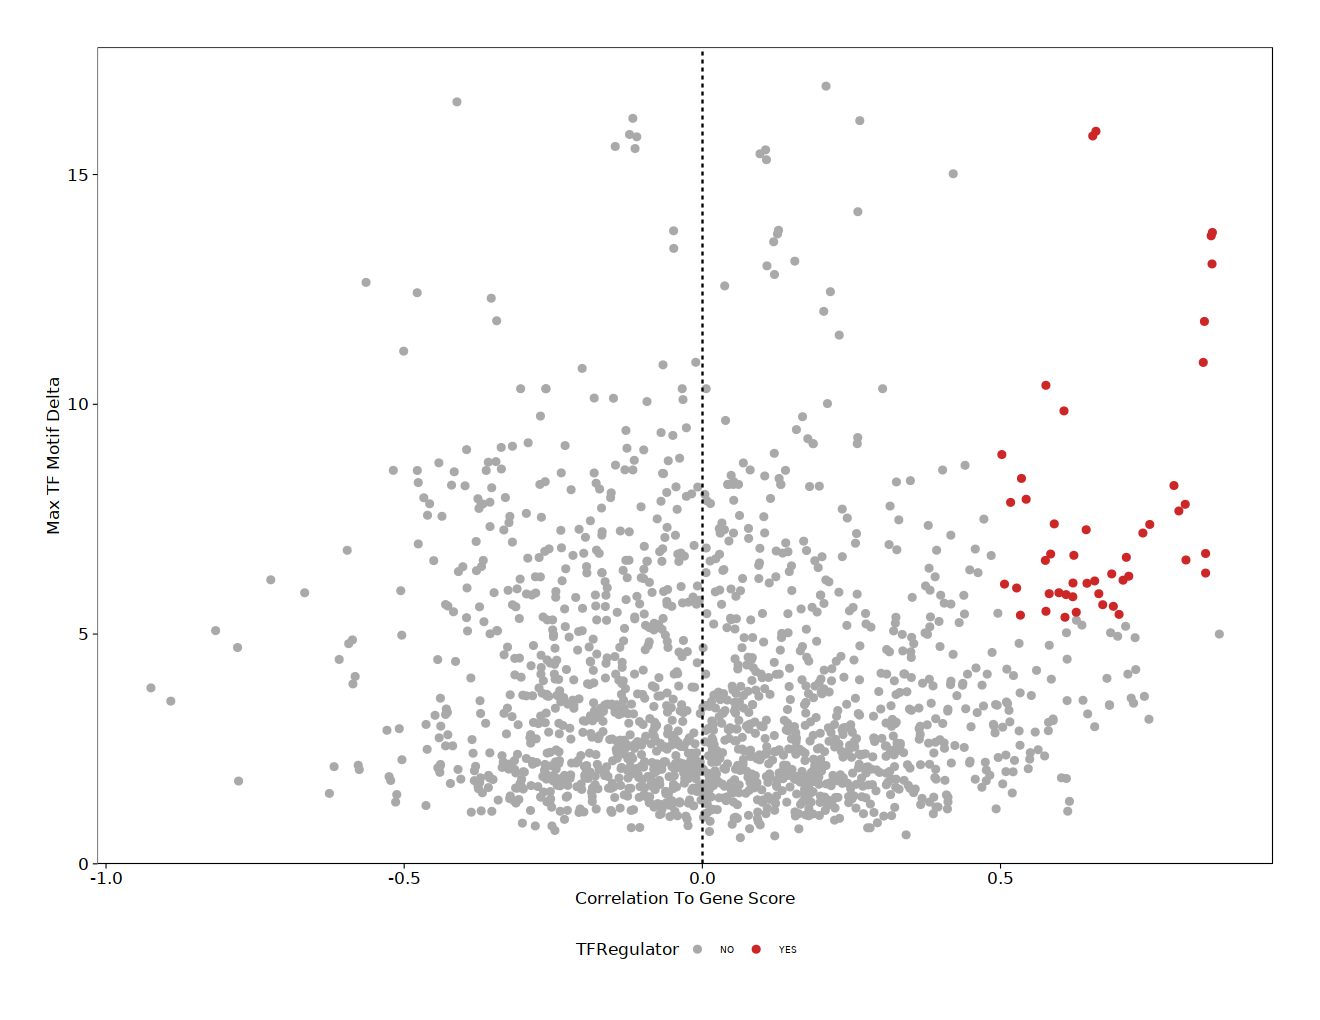

In [5]:
p <- ggplot(data.frame(corGSM_MM), aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGSM_MM$maxDelta)*1.05)
  )

p

# Gene Integration Matrix and Save

In [ ]:
### Do it with gene integration
### Make sure to use GeneIntegrationMatrix1 !!!!
corGIM_MM <- correlateMatrices(
    ArchRProj = projNeuron,
    useMatrix1 = "GeneIntegrationMatrix1",
    useMatrix2 = "MotifMatrix",
    reducedDims = "HarmonyI200"
)

corGIM_MM$maxDelta <- rowData(seZ)[match(corGIM_MM$MotifMatrix_name, rowData(seZ)$name), "maxDelta"]

In [ ]:
corGIM_MM <- corGIM_MM[order(abs(corGIM_MM$cor), decreasing = TRUE), ]
corGIM_MM <- corGIM_MM[which(!duplicated(gsub("\\-.*","",corGIM_MM[,"MotifMatrix_name"]))), ]
corGIM_MM$TFRegulator <- "NO"
corGIM_MM$TFRegulator[which(corGIM_MM$cor > 0.5 & corGIM_MM$padj < 0.01 & corGIM_MM$maxDelta > quantile(corGIM_MM$maxDelta, 0.75))] <- "YES"
sort(corGIM_MM[corGIM_MM$TFRegulator=="YES",1])

In [ ]:
saveRDS(corGIM_MM, file = here('data/tidy_data/rdas/mouse_snatac_neuron_CorGIM_MM.rds'))

# Load Gene Integration Matrix results, make figures

GLUT7: MAF, RORA
GLUT5 and 6: NR3C1
GABA3: PAX6
GLUT11: RFX2 (remove)
GLUT1: RFX2
GLUT2: LMX1B

LMX1B is important in the excitatory clusters, not inhibitory. True also in the Levine human paper
Per harmonized atlas, "mid-excitatory" Excit 21-25

PAX6: Inhib-21
Rora: Levine also found enrichment of this in the GLUT7 cells

RFX2 : no mention


In [6]:
corGIM_MM <- readRDS(file = here('data/tidy_data/rdas/mouse_snatac_neuron_CorGIM_MM.rds'))

corGIM_MM$highDeviation <- "NO"
corGIM_MM$highDeviation[which(corGIM_MM$cor <= 0.5 & corGIM_MM$cor >= 0 & corGIM_MM$maxDelta > quantile(corGIM_MM$maxDelta, 0.95))] <- "YES"
sort(corGIM_MM[corGIM_MM$highDeviation=="YES",1])

[1] "Ascl2" "Batf"  "Hmgn3" "Hoxb2" "Hoxb3" "Jdp2"  "Jdp2"  "Jdp2"  "Lmx1b"
[10] "Mafg"  "Mef2d" "Mxi1"  "Myod1" "Nfe2"  "Nfe2"  "Nfe2"  "Pax7"  "Prrx2"
[19] "Tal1"  "Tal1"  "Tal1"  "Tal1"  "Tal1"

In [7]:
## overlap of corGIM_MM in CorGSM_MM
sum(corGIM_MM[corGIM_MM$TFRegulator == 'YES',]$MotifMatrix_name %in% corGSM_MM[corGSM_MM$TFRegulator == 'YES',]$MotifMatrix_name)/length(corGIM_MM[corGIM_MM$TFRegulator == 'YES',]$MotifMatrix_name)
# Just use corGIM_MM, its almost the same thing and arguably the better one

[1] 0.8928571

In [8]:
sort(corGIM_MM[corGIM_MM$TFRegulator=="YES",2])

[1] "LMX1B_1825" "MAF_1005"   "MAF_1630"   "MAF_1631"   "MAF_1632"  
 [6] "MAF_1633"   "MAF_1634"   "MAF_1635"   "MAF_22"     "NR3C1_1901"
[11] "NR3C1_1902" "NR3C1_1930" "NR3C1_73"   "NR3C1_730"  "PAX2_1442" 
[16] "PAX5_1446"  "PAX5_77"    "PAX6_351"   "PAX6_873"   "RFX2_1480" 
[21] "RFX2_1481"  "RFX2_1488"  "RFX2_1489"  "RORA_395"   "RORA_396"  
[26] "RORA_821"   "RORA_875"   "RORA_876"

In [9]:
### TF regulators

quantile_cutoff = as.numeric(quantile(corGIM_MM$maxDelta, 0.75))

p <- ggplot(data.frame(corGIM_MM), aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0.5, lty = "dashed") + 
  geom_hline(yintercept = quantile_cutoff, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGIM_MM$maxDelta)*1.05)
  )

pdf(here(paste0("figures/exploratory/arokiaraj_paper/motifs/","motif_chromVarExpression_cutoffs",Sys.Date(),".pdf")), width = 3.75, height = 4.5)
print(p)
dev.off()

png 
  2

In [10]:
### high deviation not considered regulators

quantile_cutoff = as.numeric(quantile(corGIM_MM$maxDelta, 0.95))

q <- ggplot(data.frame(corGIM_MM), aes(cor, maxDelta, color = highDeviation)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0.5, lty = "dashed") + 
  geom_vline(xintercept = 0, lty = "dashed") +
  geom_hline(yintercept = quantile_cutoff, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="blue")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGIM_MM$maxDelta)*1.05)
  )

pdf(here(paste0("figures/exploratory/arokiaraj_paper/motifs/","motif_chromVarExpression_highDevNotRegulators",Sys.Date(),".pdf")), width = 3.75, height = 4.5)
print(q)
dev.off()

png 
  2

In [19]:
x = rowData(seZ[rowData(seZ)$name %in% corGIM_MM[corGIM_MM$TFRegulator=="YES",2],])$name
seZ_sigTFs = seZ[rowData(seZ)$name %in% corGIM_MM[corGIM_MM$TFRegulator=="YES",2],]

In [20]:
seZ_sigTFs

class: SummarizedExperiment 
dim: 28 18 
metadata(0):
assays(1): MotifMatrix
rownames(28): f2087 f2138 ... f3967 f3995
rowData names(4): seqnames idx name maxDelta
colnames(18): GABA1 GABA2_1 ... GLUT8 GLUT9
colData names(22): TSSEnrichment ReadsInTSS ... FRIP nCells

In [21]:
names(x) = rowData(seZ_sigTFs[names(x),])$name

In [22]:
maf_df = rowData(seZ_sigTFs)[grepl('MAF',rowData(seZ_sigTFs)$name),]
maf_df

DataFrame with 8 rows and 4 columns
      seqnames     idx     name         maxDelta
         <Rle> <array>  <array>        <numeric>
f2087        z      22   MAF_22 10.4129378227482
f3070        z    1005 MAF_1005 5.63883978539725
f3695        z    1630 MAF_1630 6.15577322310978
f3696        z    1631 MAF_1631 8.23240627858886
f3697        z    1632 MAF_1632 6.10482207480309
f3698        z    1633 MAF_1633 7.67896137380555
f3699        z    1634 MAF_1634 5.60354852560234
f3700        z    1635 MAF_1635 7.82349053849519

In [23]:
maf_correlations = corGIM_MM[corGIM_MM$MotifMatrix_name %in% maf_df$name,]
maf_correlations

DataFrame with 8 rows and 17 columns
  GeneIntegrationMatrix1_name MotifMatrix_name               cor
                      <array>          <array>         <numeric>
1                         Maf         MAF_1635 0.725345130112194
2                         Maf         MAF_1631 0.712061364918831
3                         Maf         MAF_1633 0.705638695765116
4                         Maf         MAF_1005 0.647444044145487
5                         Maf         MAF_1632 0.642359820219155
6                         Maf         MAF_1634 0.637691749018603
7                         Maf         MAF_1630 0.628908999521961
8                         Maf           MAF_22 0.536022239622712
                  padj                 pval GeneIntegrationMatrix1_seqnames
             <numeric>            <numeric>                           <Rle>
1 1.54132630627216e-75 9.93762931187722e-79                            chr8
2 1.79162399384097e-71  1.1551411952553e-74                            chr8
3 1.37077

In [11]:
plotVarDev <- getVarDeviations(projNeuron, name = "MotifMatrix", plot = TRUE, n = 0)
plotPDF(plotVarDev, name = "Variable-Motif-Deviation-Scores", width = 3.75, height = 5, ArchRProj = projNeuron, addDOC = FALSE)

DataFrame with 6 rows and 6 columns
     seqnames     idx      name     combinedVars      combinedMeans      rank
        <Rle> <array>   <array>        <numeric>          <numeric> <integer>
f48         z      48 TCF7L2_48 105.631762493573 -0.168216190968534         1
f59         z      59  EP300_59  103.24688734114 -0.157663535400237         2
f96         z      96  TFAP2_96  101.61260684042 -0.171993271835219         3
f56         z      56  SMARC_56 100.957821333442 -0.163558886247756         4
f714        z     714   AP1_714 98.0098610209277 -0.179622405717924         5
f74         z      74    MYC_74 97.1228272712361 -0.175138068078643         6


Plotting Ggplot!



In [ ]:
# plotVarDevFocused <- getVarDeviations(projNeuron, name = "MotifMatrix", plot = TRUE) + xlim(0,30) + ylim(60,120) + theme(legend.position = 'none')
# plotPDF(plotVarDevFocused, name = "Variable-Motif-Deviation-Scores-Focused", width = 3.75, height = 5, ArchRProj = projNeuron, addDOC = FALSE)
# plotVarDevFocused

In [ ]:
varDevsRanked <- getVarDeviations(projNeuron, name = "MotifMatrix", plot = FALSE)
varDevsRanked$name[1:100]

In [13]:
# motifs = c('LMX1B', 'MAF', 'NR3C1', 'PAX2', 'PAX5', 'PAX6', 'RFX2', 'RORA')
# markerMotifs <- getFeatures(projNeuron, select = paste(motifs, collapse="|"), useMatrix = "MotifMatrix")
# markerMotifs <- grep("z:", markerMotifs, value = TRUE)
# class(markerMotifs)

motifs = sort(corGIM_MM[corGIM_MM$TFRegulator=="YES",2])
motifs_w_z = paste0('z:', motifs)
motifs_w_z

[1] "z:LMX1B_1825" "z:MAF_1005"   "z:MAF_1630"   "z:MAF_1631"   "z:MAF_1632"  
 [6] "z:MAF_1633"   "z:MAF_1634"   "z:MAF_1635"   "z:MAF_22"     "z:NR3C1_1901"
[11] "z:NR3C1_1902" "z:NR3C1_1930" "z:NR3C1_73"   "z:NR3C1_730"  "z:PAX2_1442" 
[16] "z:PAX5_1446"  "z:PAX5_77"    "z:PAX6_351"   "z:PAX6_873"   "z:RFX2_1480" 
[21] "z:RFX2_1481"  "z:RFX2_1488"  "z:RFX2_1489"  "z:RORA_395"   "z:RORA_396"  
[26] "z:RORA_821"   "z:RORA_875"   "z:RORA_876"

In [14]:
highDev_motifs = sort(corGIM_MM[corGIM_MM$highDeviation=="YES",2])
highDev_motifs_w_z = paste0('z:', highDev_motifs)
highDev_motifs_w_z

[1] "z:ASCL2_1553" "z:BATF_39"    "z:HMGN3_124"  "z:HOXB2_1776" "z:HOXB3_1777"
 [6] "z:JDP2_1622"  "z:JDP2_1624"  "z:JDP2_1626"  "z:LMX1B_1826" "z:MAFG_1629" 
[11] "z:MEF2D_1404" "z:MXI1_47"    "z:MYOD1_411"  "z:NFE2_1637"  "z:NFE2_310"  
[16] "z:NFE2_8"     "z:PAX7_1203"  "z:PRRX2_1878" "z:TAL1_328"   "z:TAL1_329"  
[21] "z:TAL1_332"   "z:TAL1_759"   "z:TAL1_890"

In [15]:
mef2_motifs = varDevsRanked$name[grepl('MEF',varDevsRanked$name)]
mef2_motifs_w_z = paste0('z:', mef2_motifs)
mef2_motifs_w_z

ERROR: Error in eval(expr, envir, enclos): object 'varDevsRanked' not found


In [ ]:
length(varDevsRanked$name)

In [16]:
projNeuron = projNeuron[projNeuron$FINAL_GROUP_LABEL != 'GLUT11']
projNeuron = projNeuron[projNeuron$FINAL_GROUP_LABEL != 'GLUT9']

p <- plotGroups(ArchRProj = projNeuron, 
  groupBy = "FINAL_GROUP_LABEL", 
  colorBy = "MotifMatrix", 
  name = motifs_w_z,
  imputeWeights = getImputeWeights(projNeuron),
  baseSize = 9
)

Getting ImputeWeights

No imputeWeights found, returning NULL

Getting Matrix Values...

2023-12-18 12:39:31 : 

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


1 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
2 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
3 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
4 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
5 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
6 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
7 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
8 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
9 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
10 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
11 
Warning message:
“`expand_scale

Getting ImputeWeights

No imputeWeights found, returning NULL

Getting Matrix Values...

2023-12-18 12:40:33 : 

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


1 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
2 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
3 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
4 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
5 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
6 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
7 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
8 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
9 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
10 
Warning message:
“`expand_scale()` is deprecated; use `expansion()` instead.”
11 
Warning message:
“`expand_scale

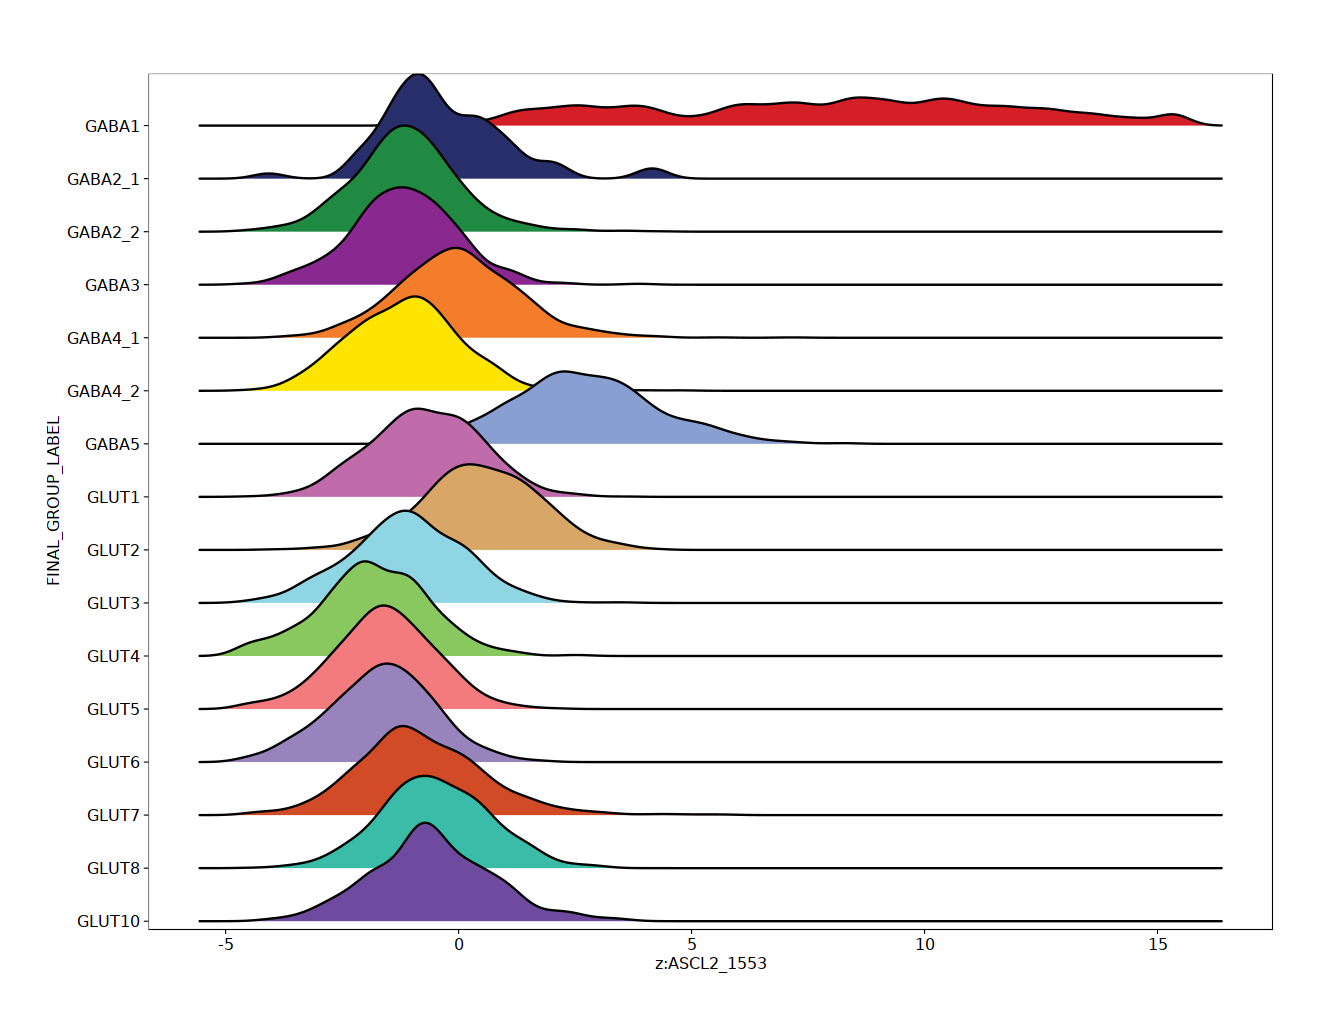

Picking joint bandwidth of 1.13

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


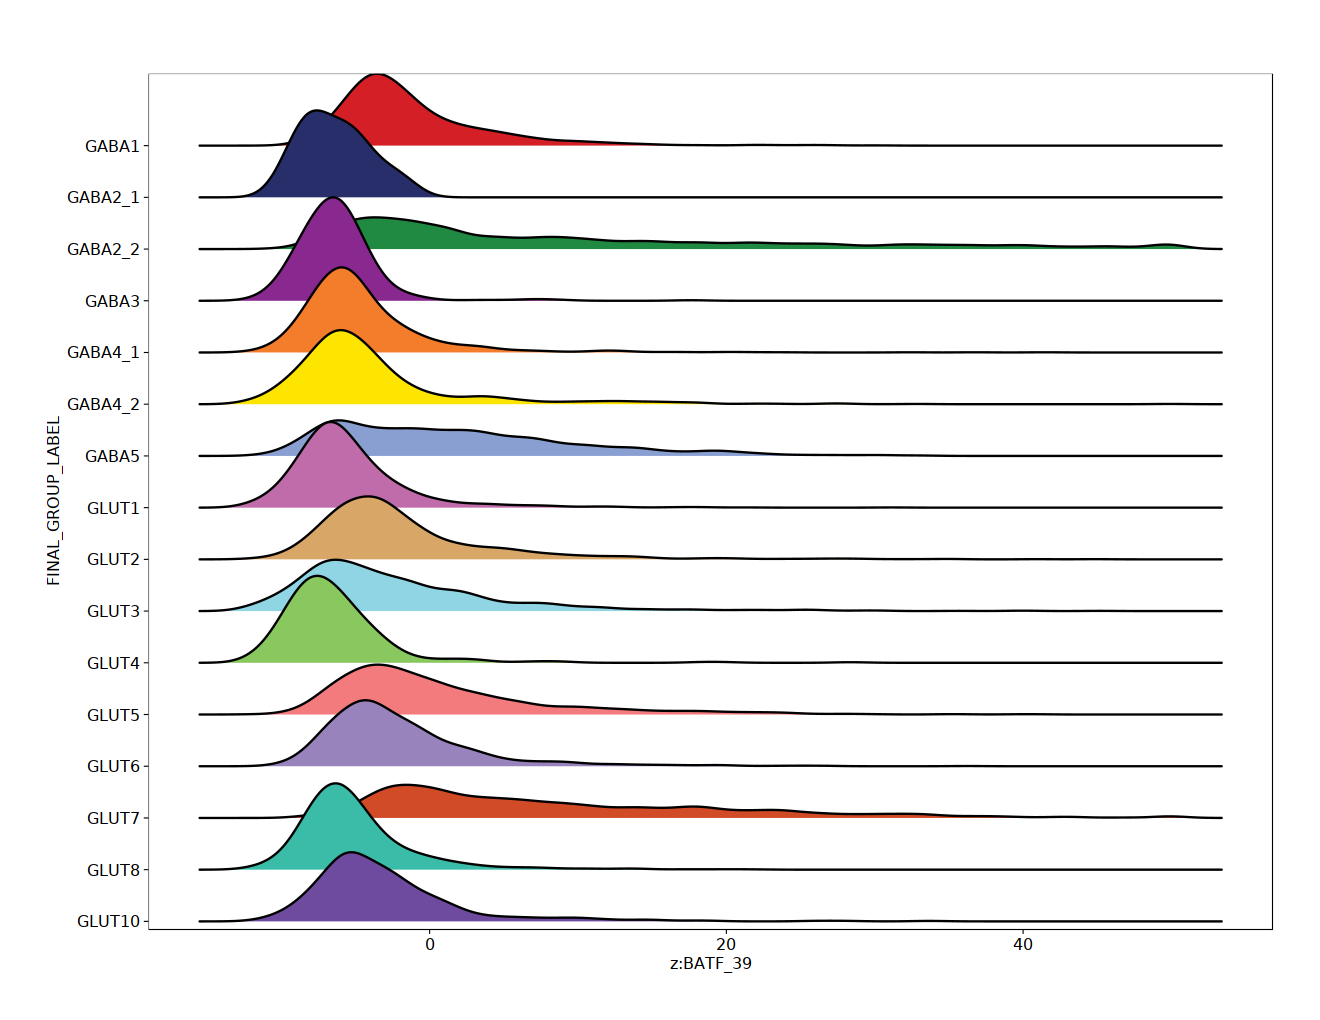

Picking joint bandwidth of 0.438

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


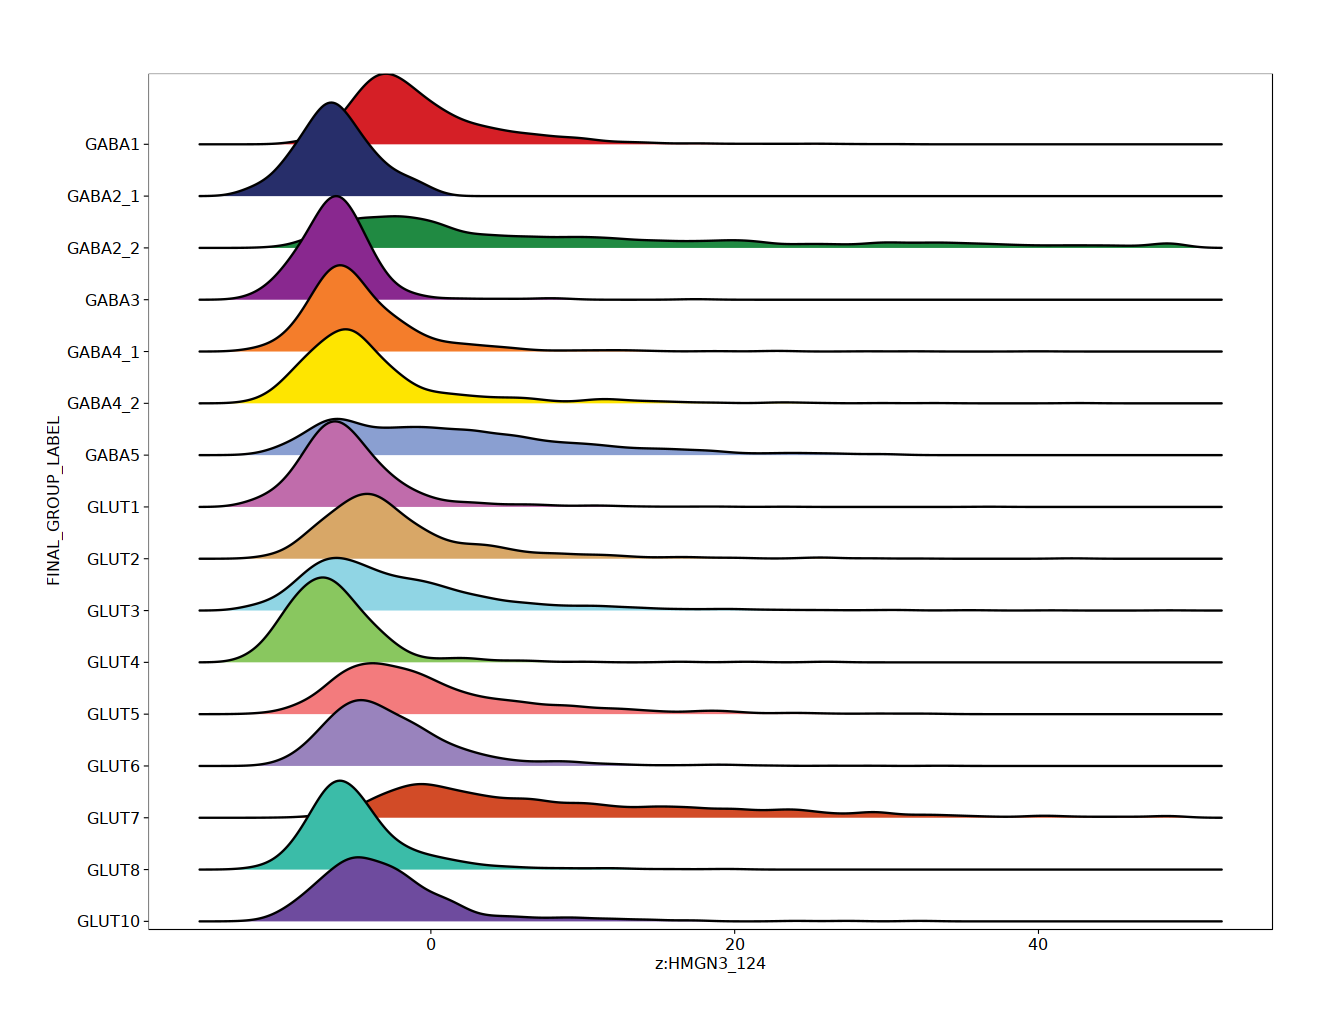

Picking joint bandwidth of 0.448

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


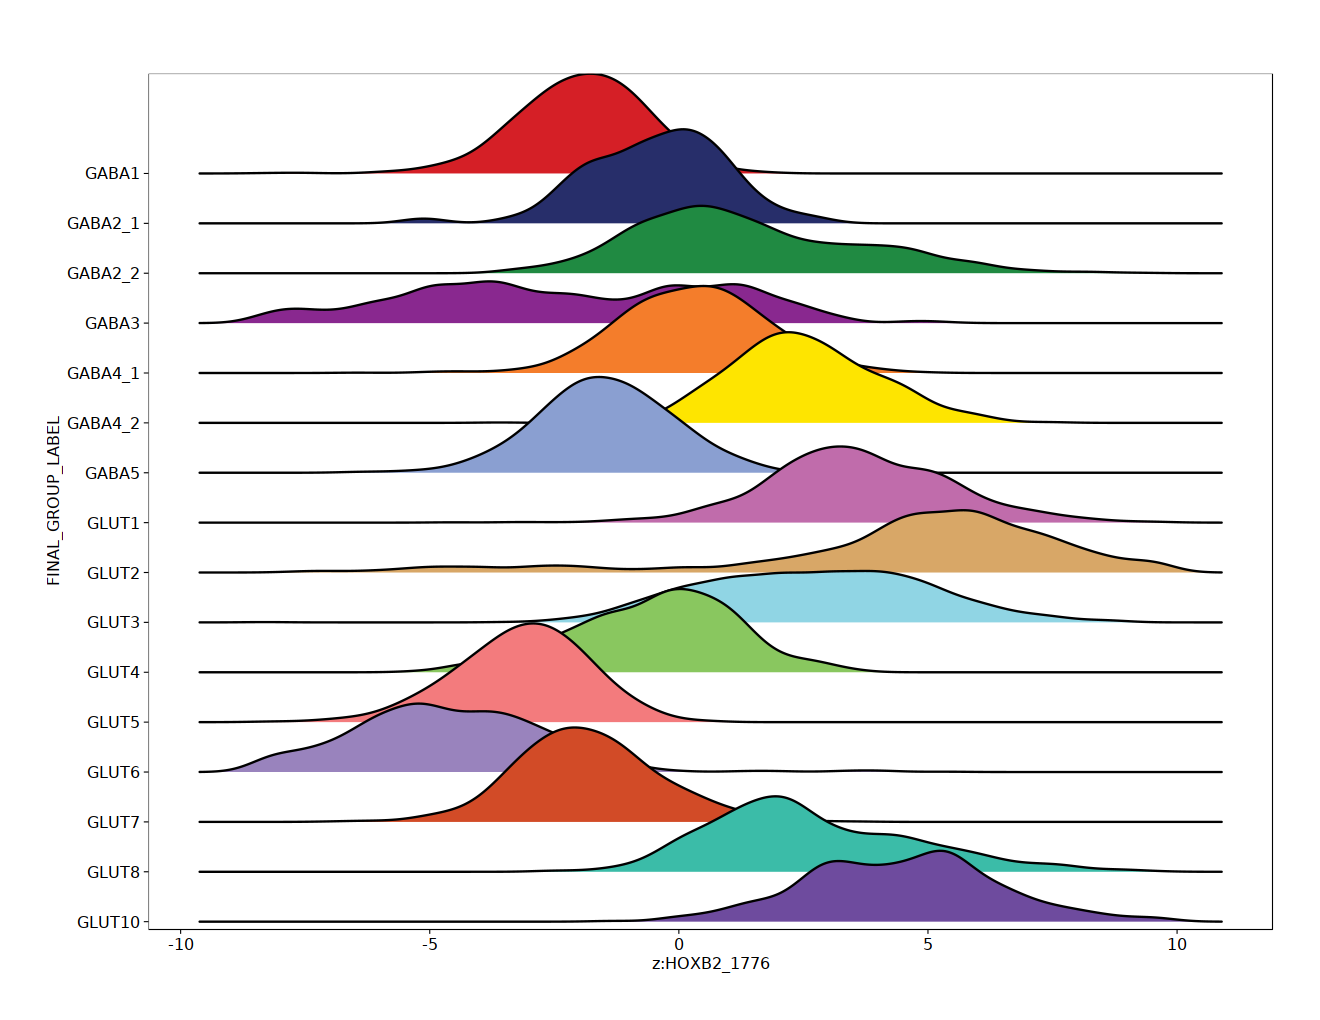

Picking joint bandwidth of 0.839

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


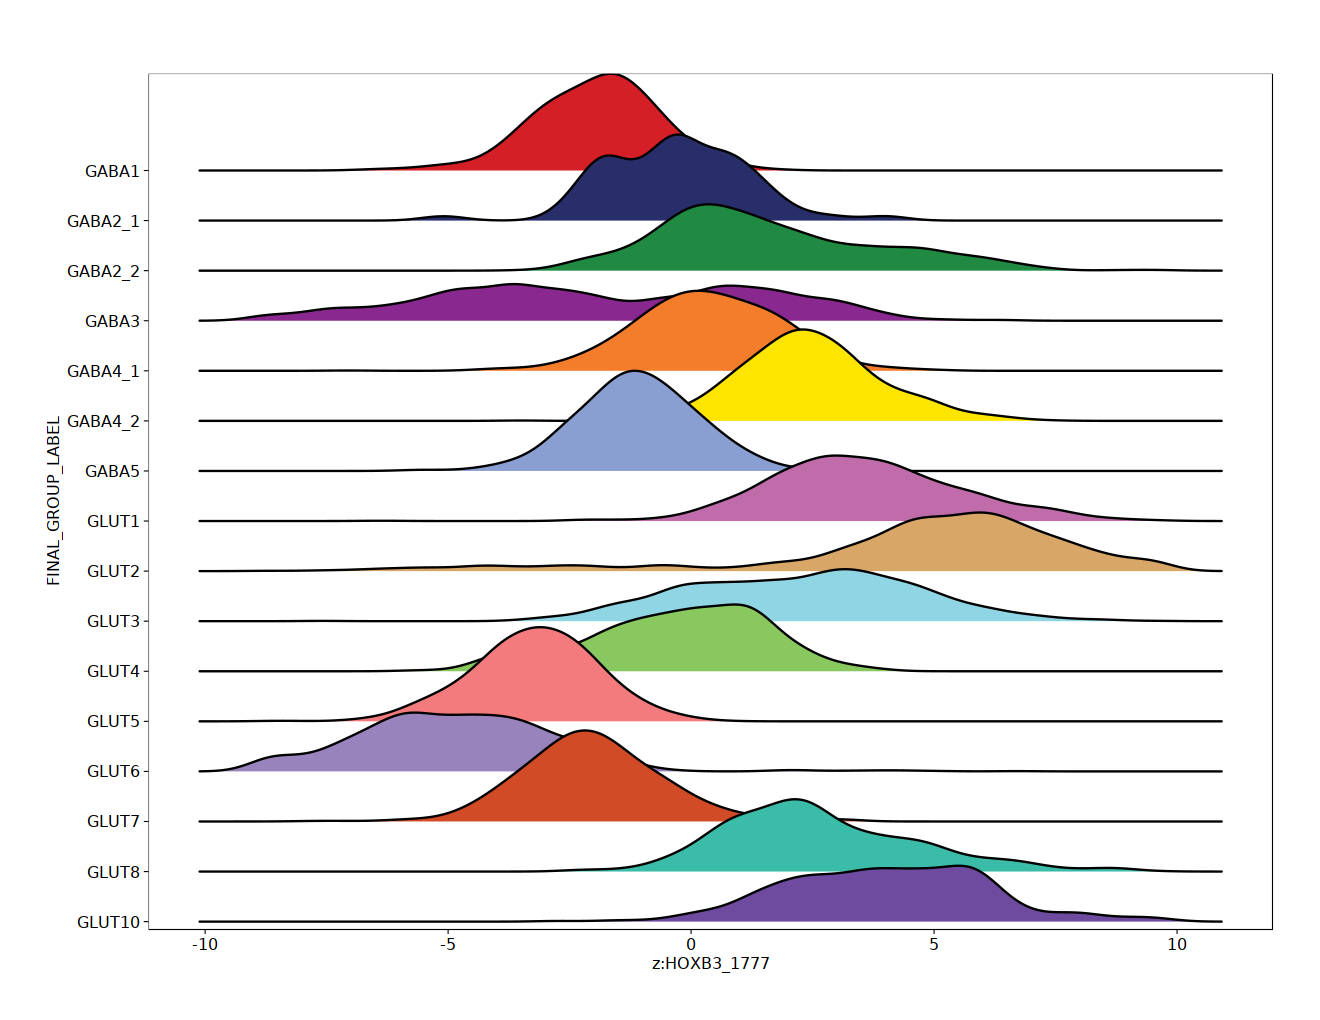

Picking joint bandwidth of 0.896

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


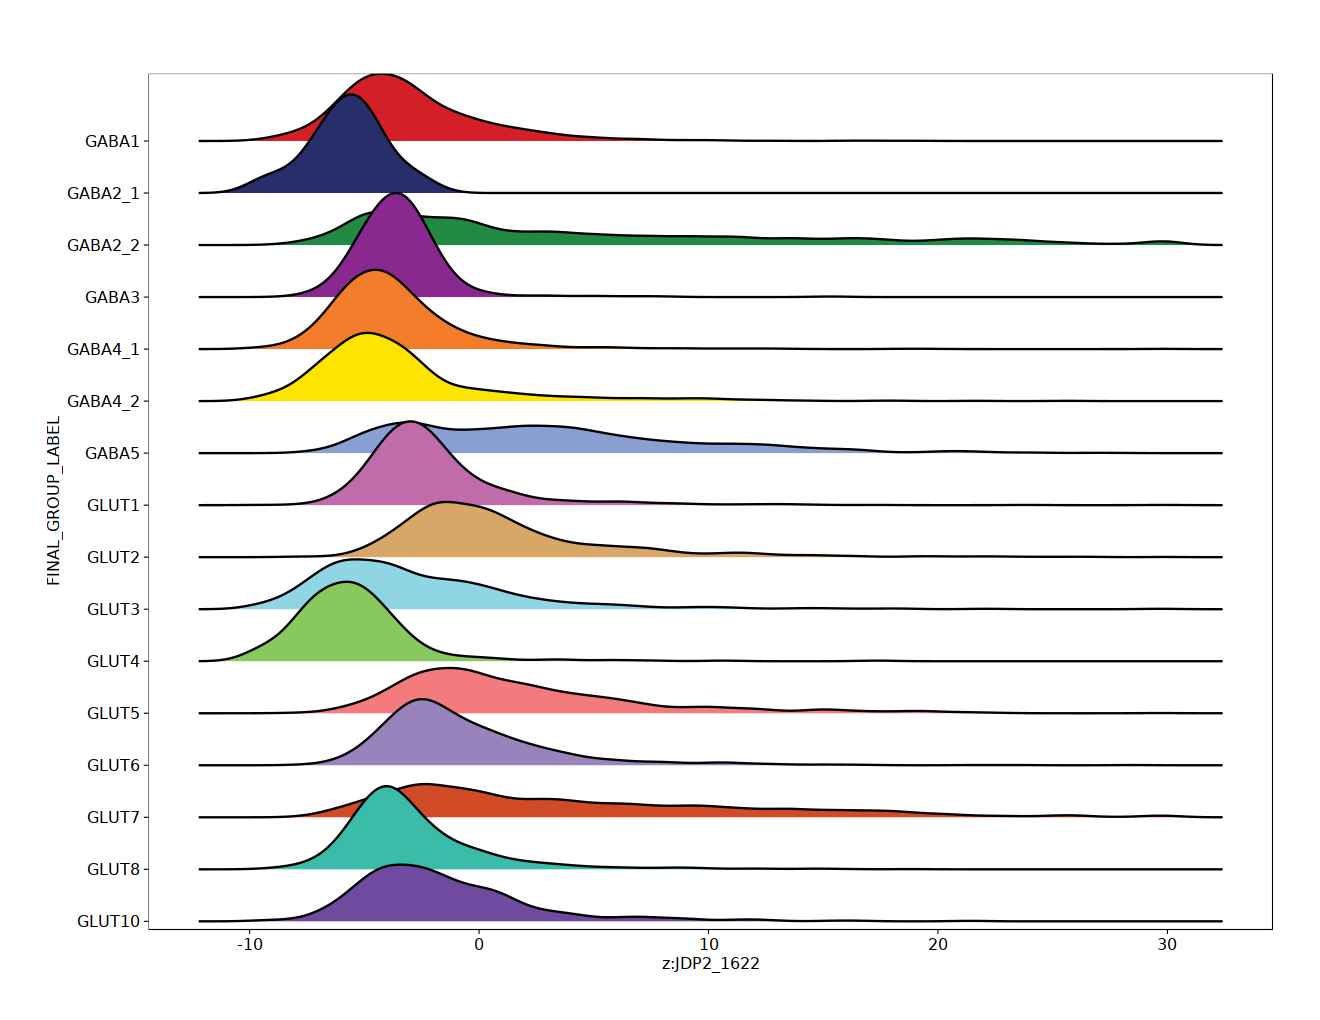

Picking joint bandwidth of 0.985

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


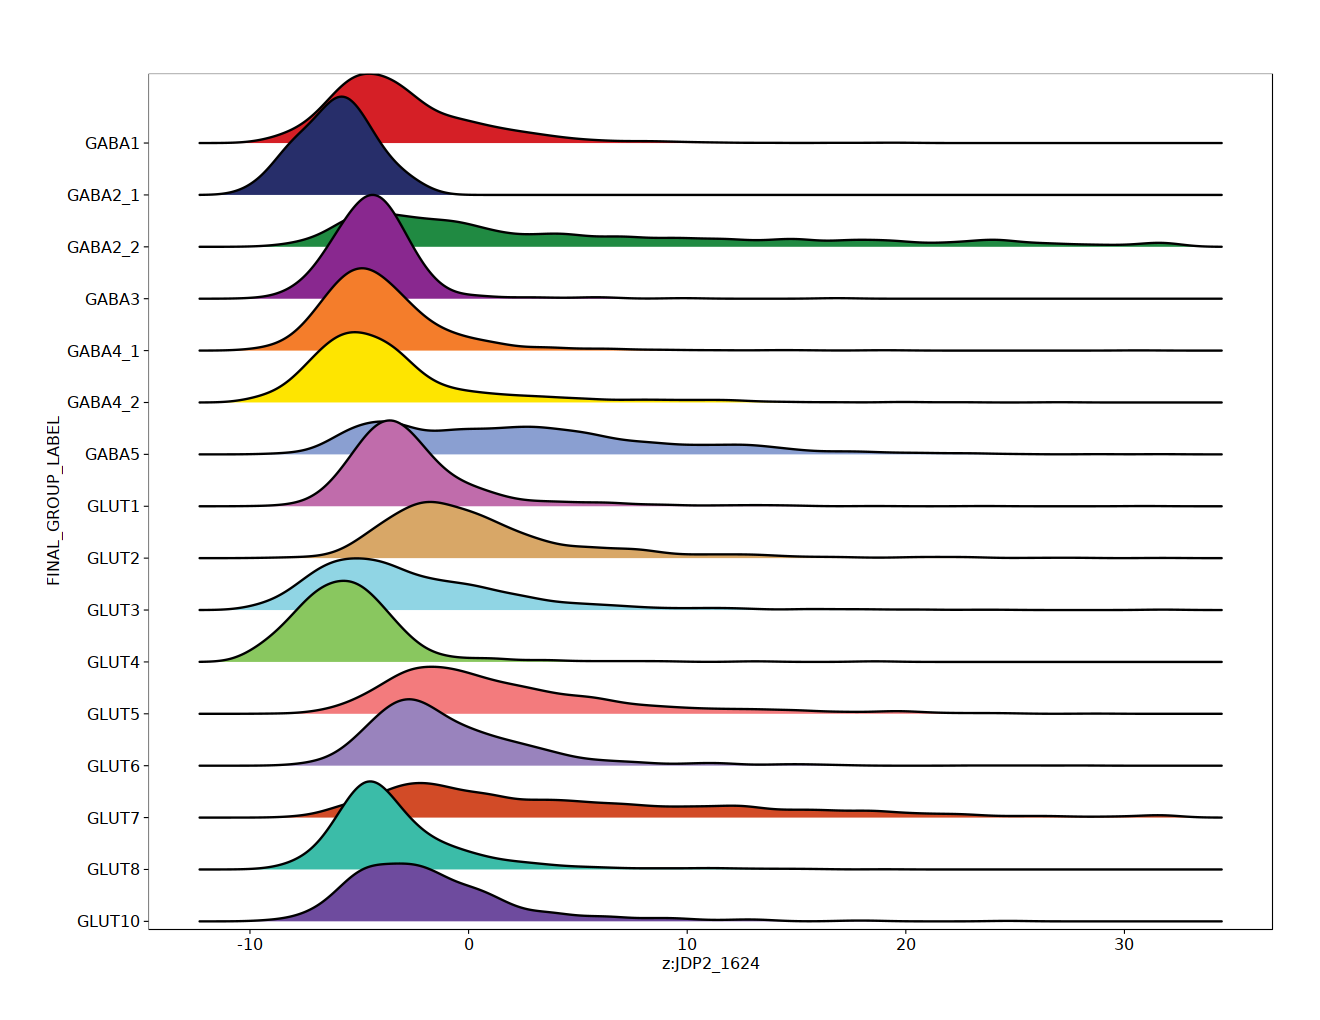

Picking joint bandwidth of 0.494

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


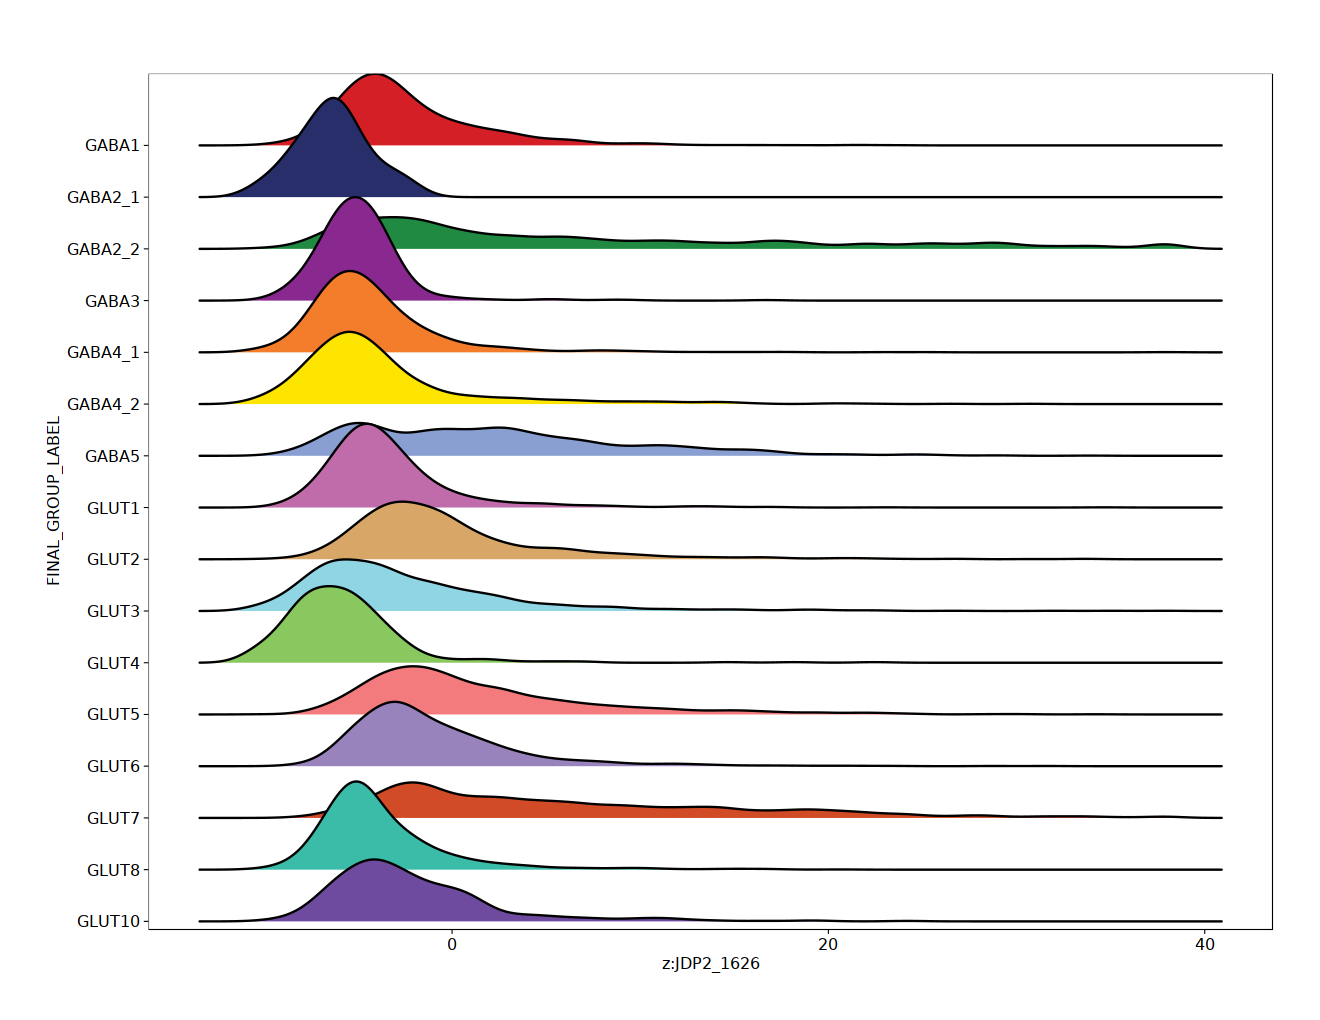

Picking joint bandwidth of 0.404

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


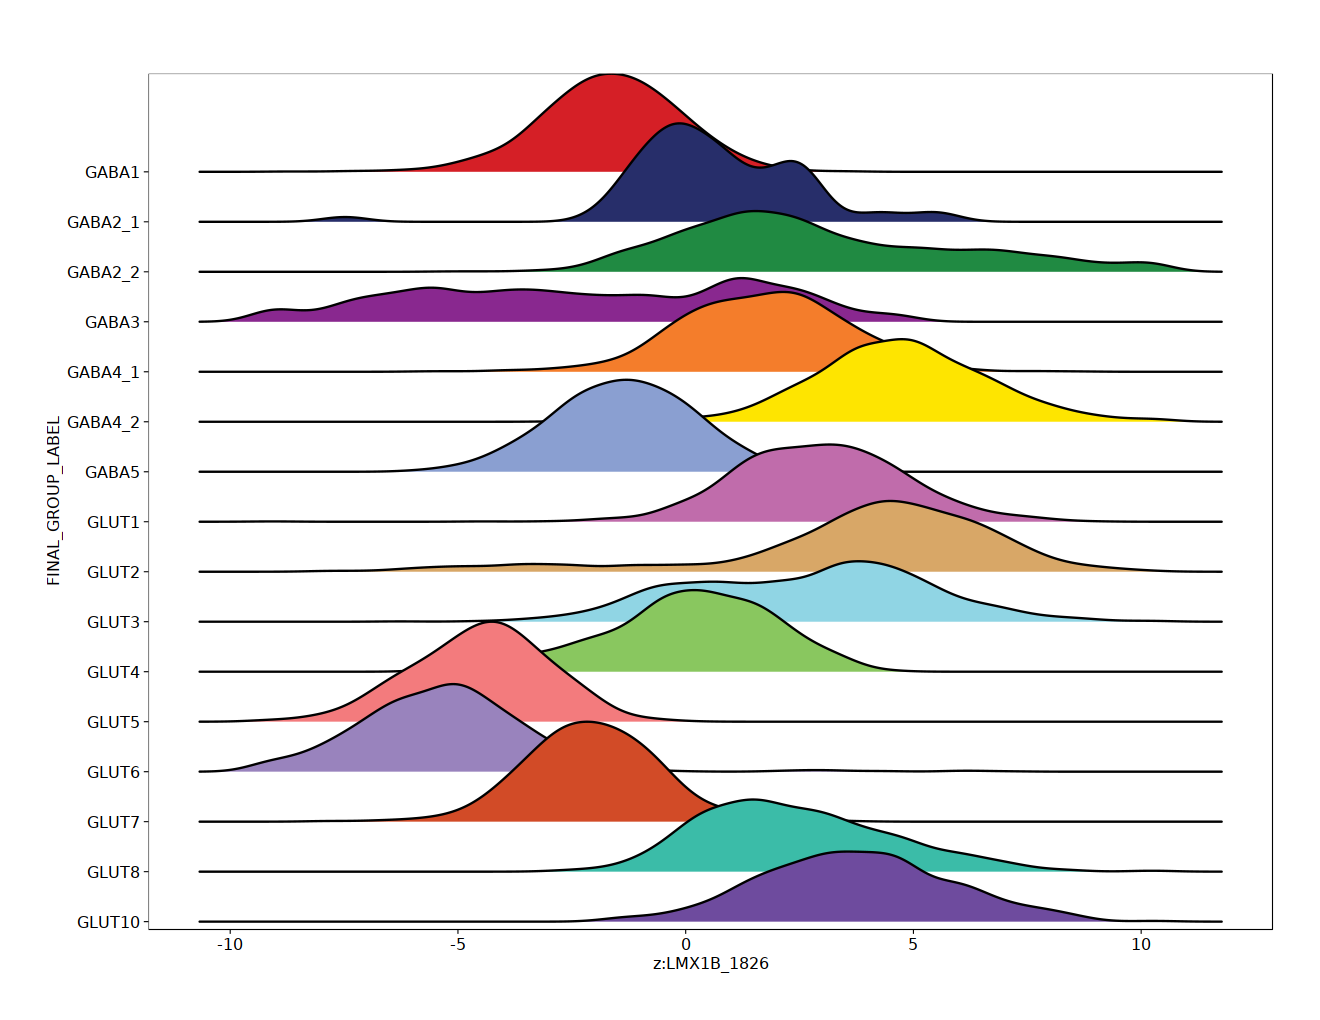

Picking joint bandwidth of 0.665

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


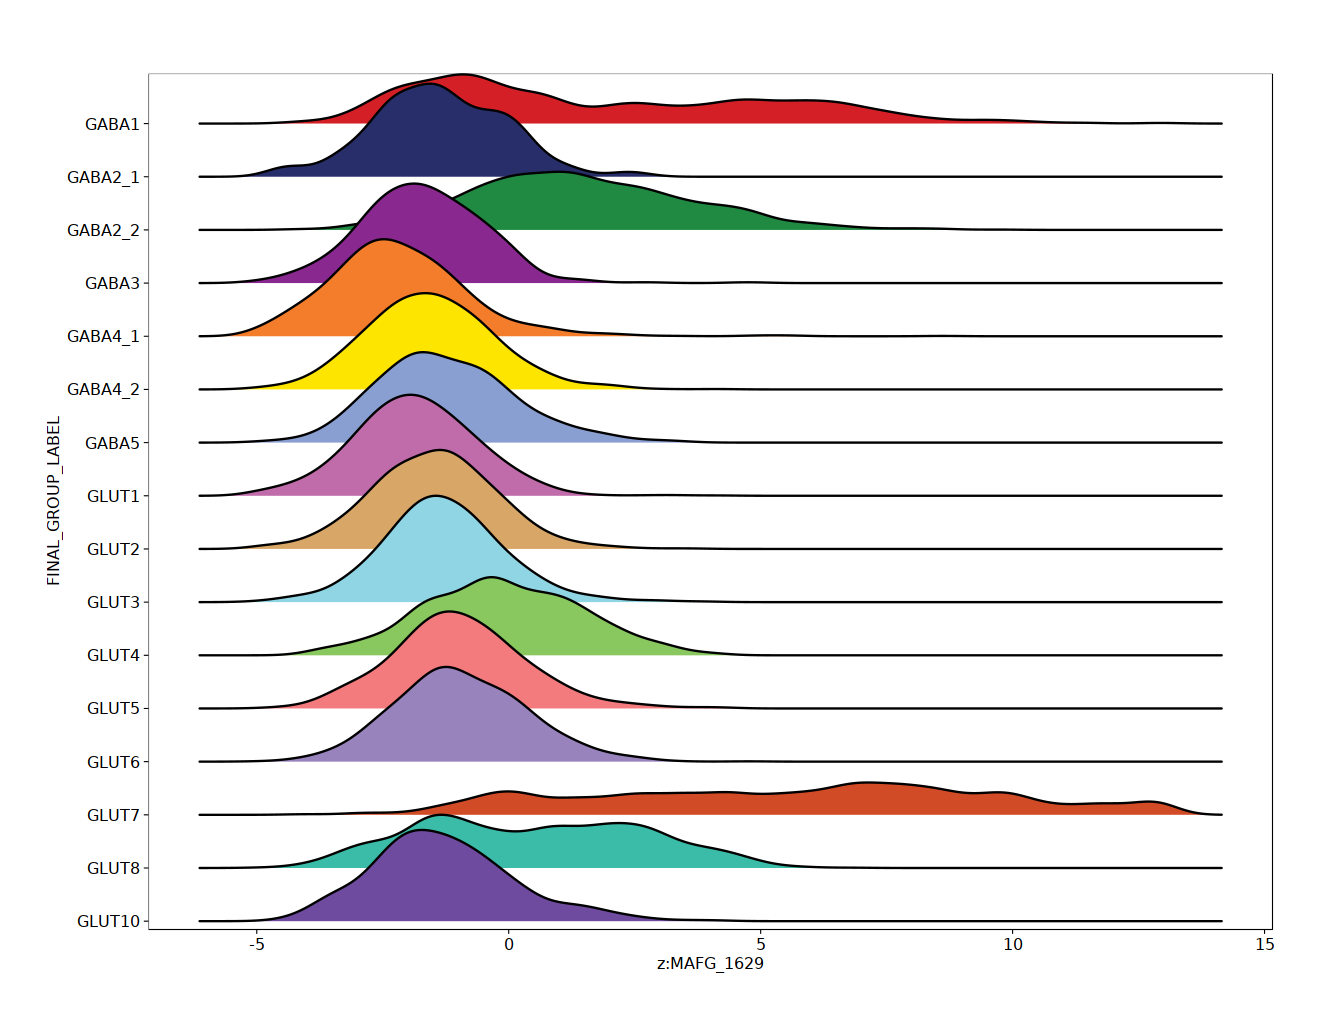

Picking joint bandwidth of 0.496

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


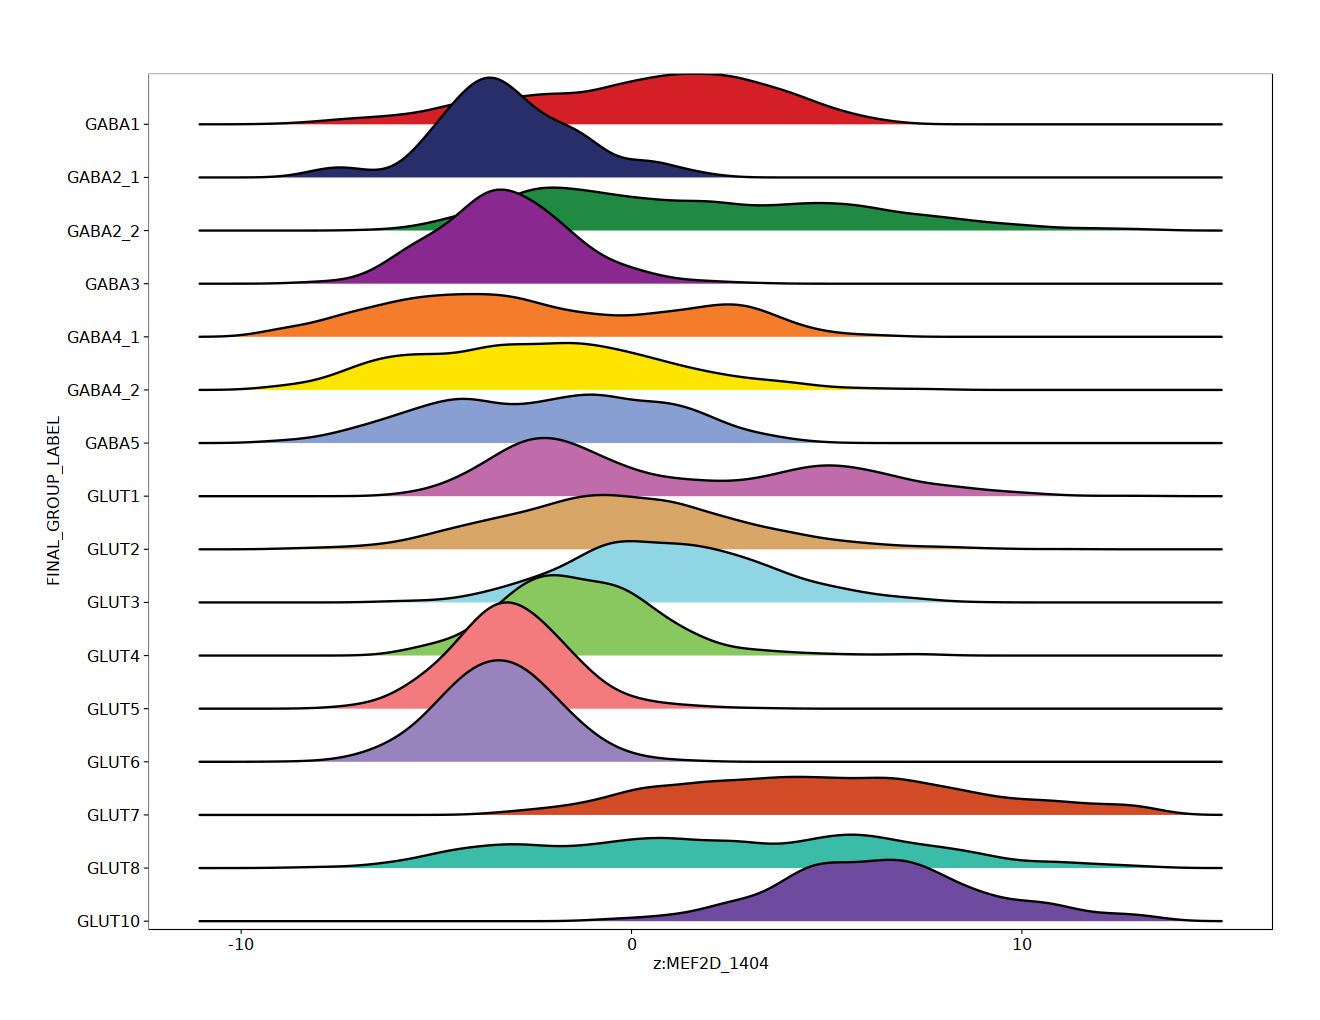

Picking joint bandwidth of 0.358

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


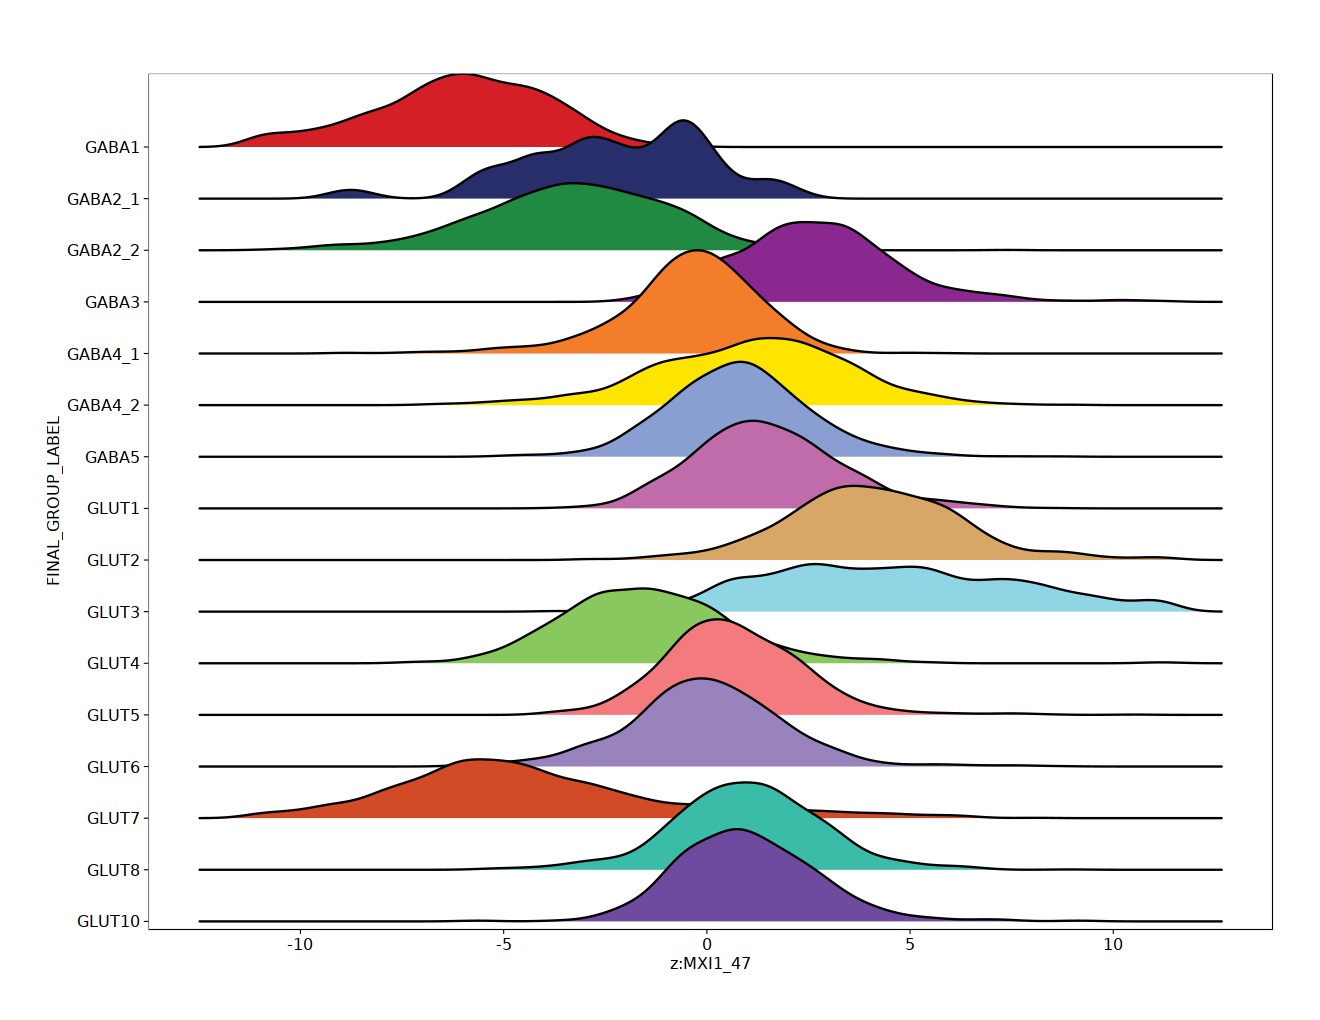

Picking joint bandwidth of 0.887

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


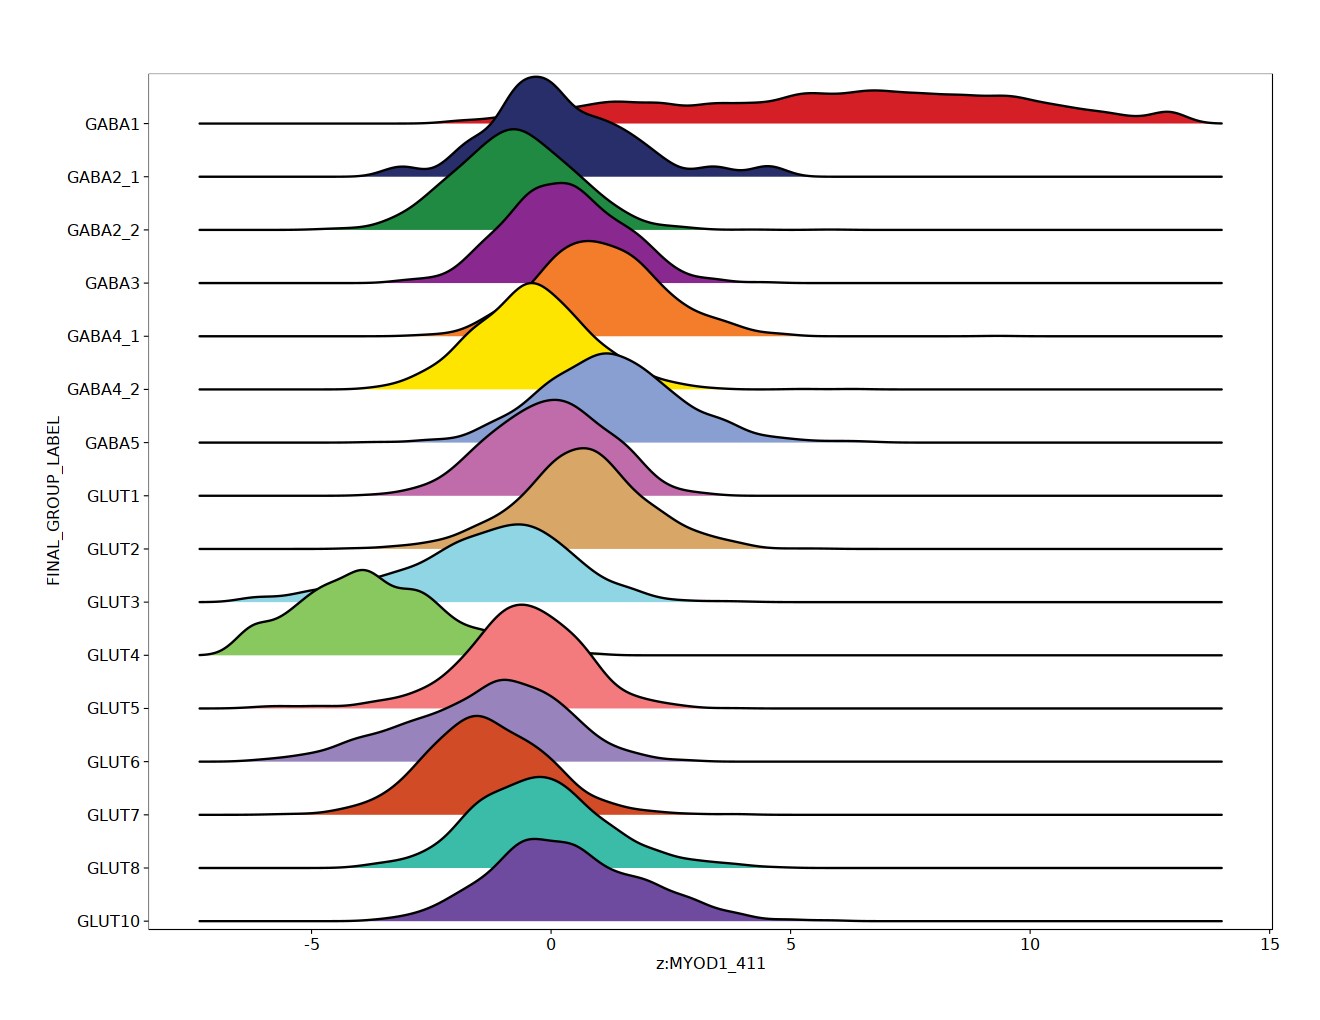

Picking joint bandwidth of 0.656

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


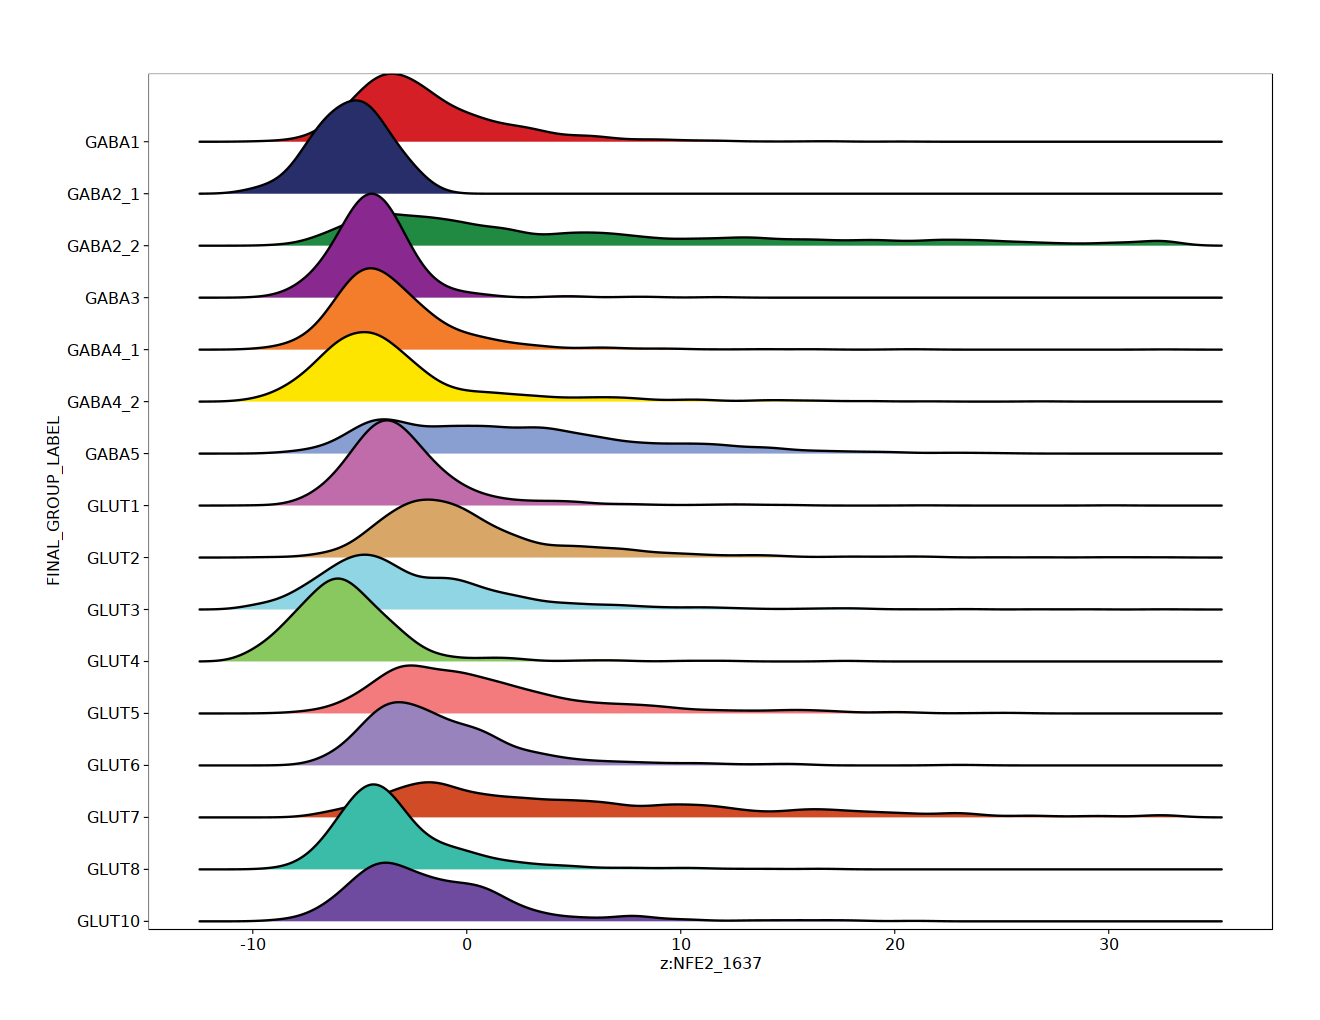

Picking joint bandwidth of 0.699

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


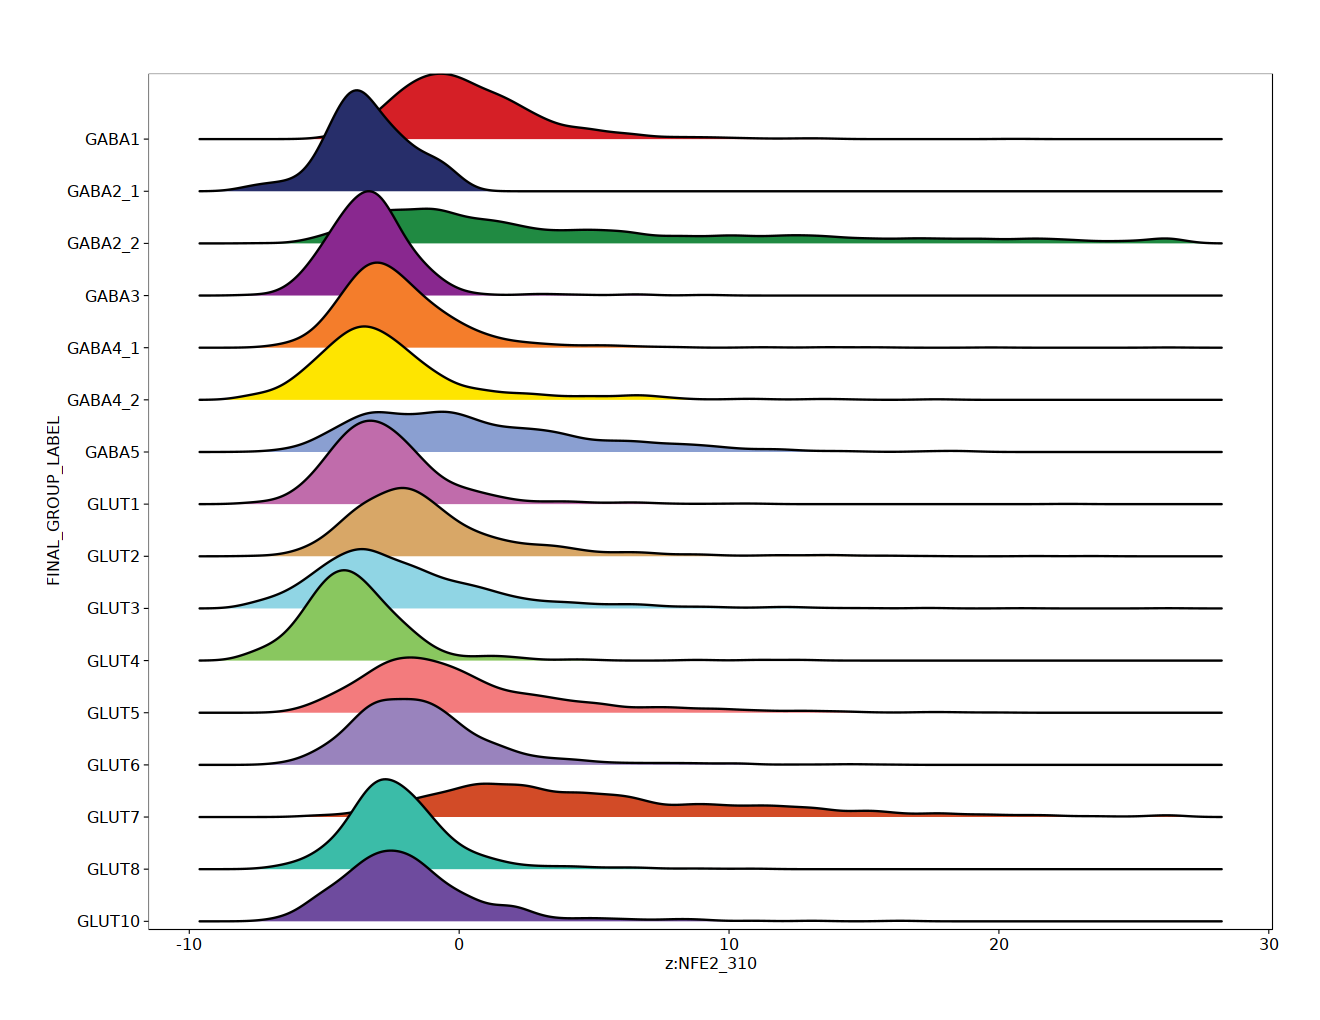

Picking joint bandwidth of 0.446

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


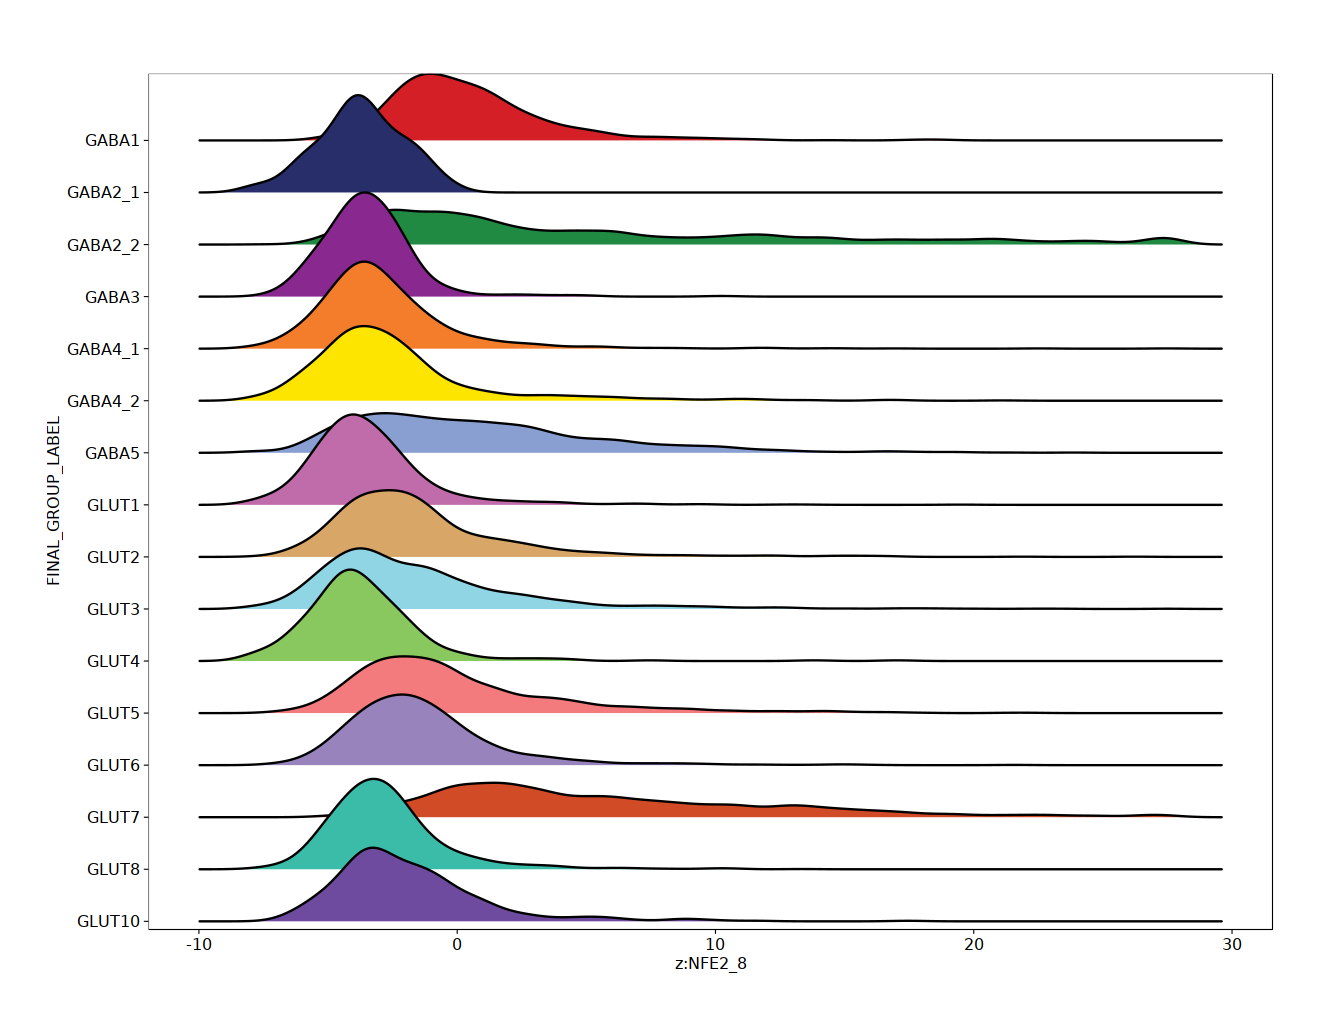

Picking joint bandwidth of 0.489

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


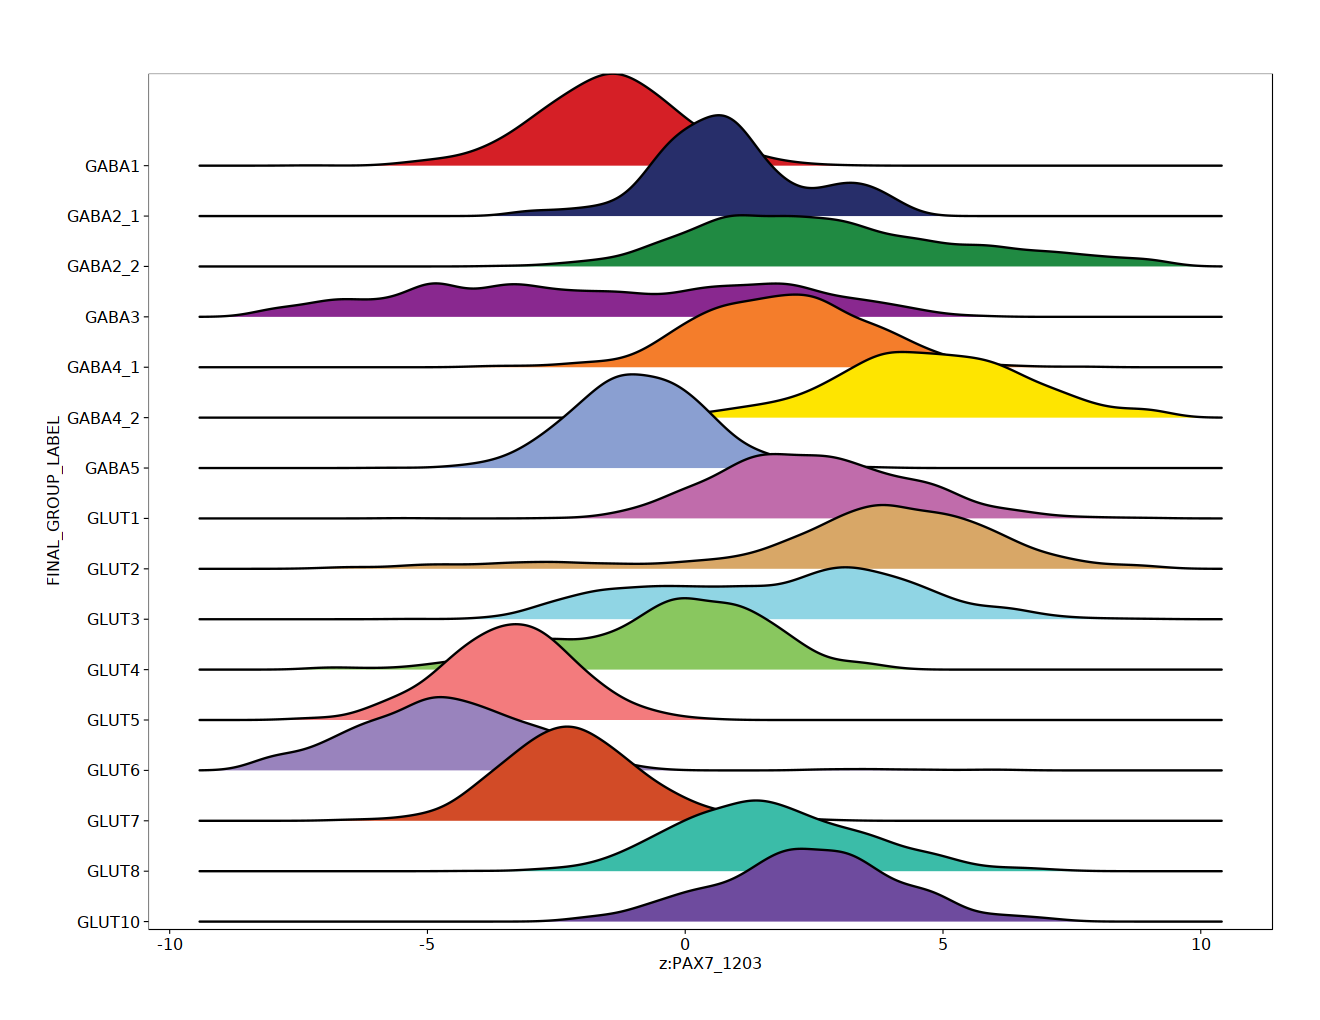

Picking joint bandwidth of 0.372

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


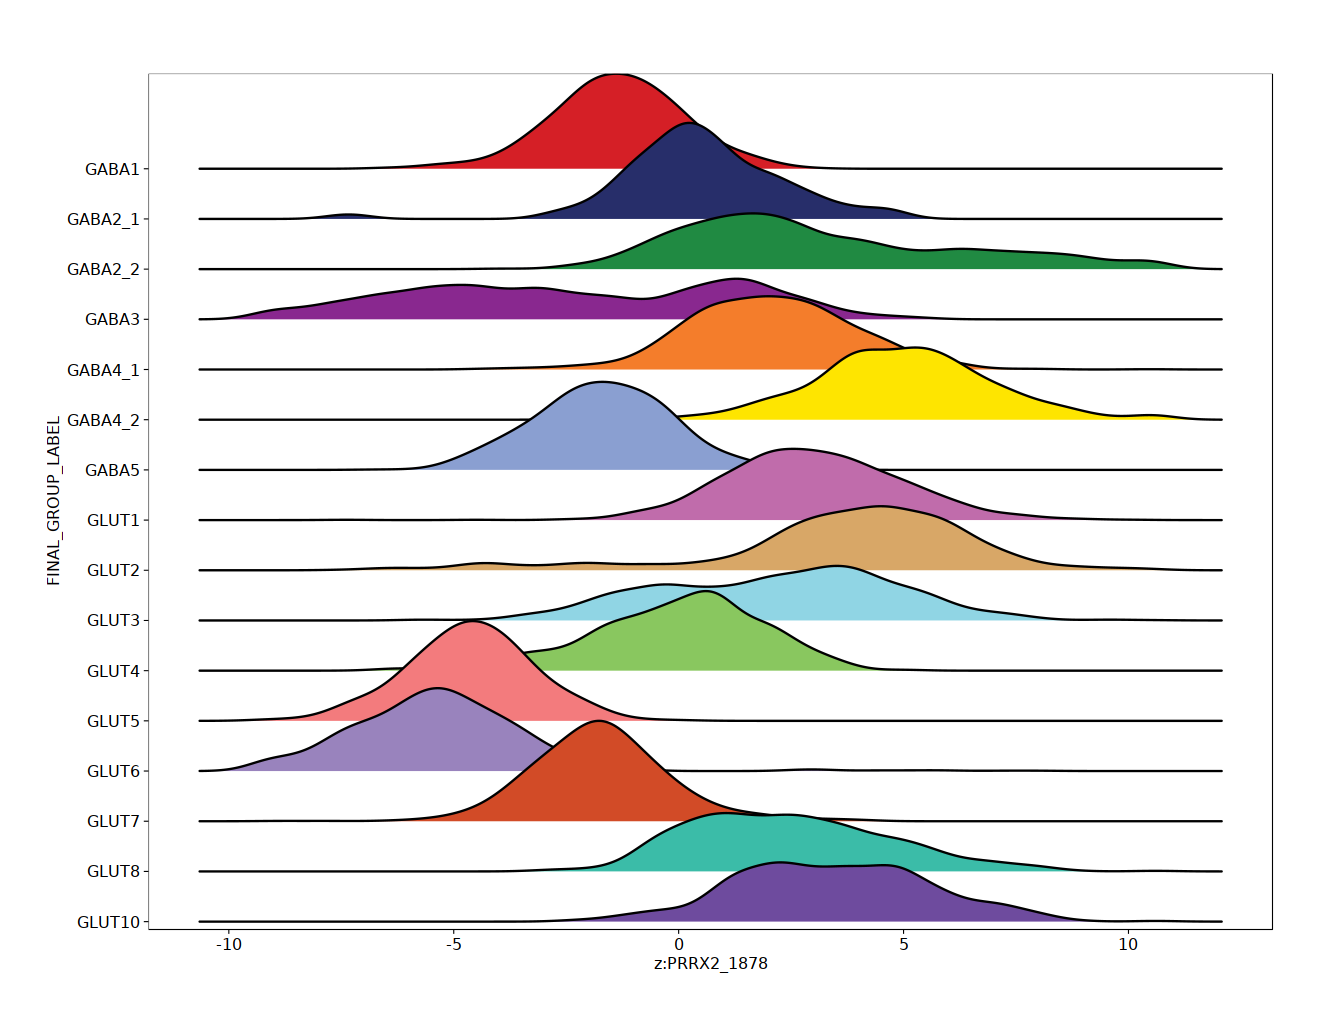

Picking joint bandwidth of 0.378

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


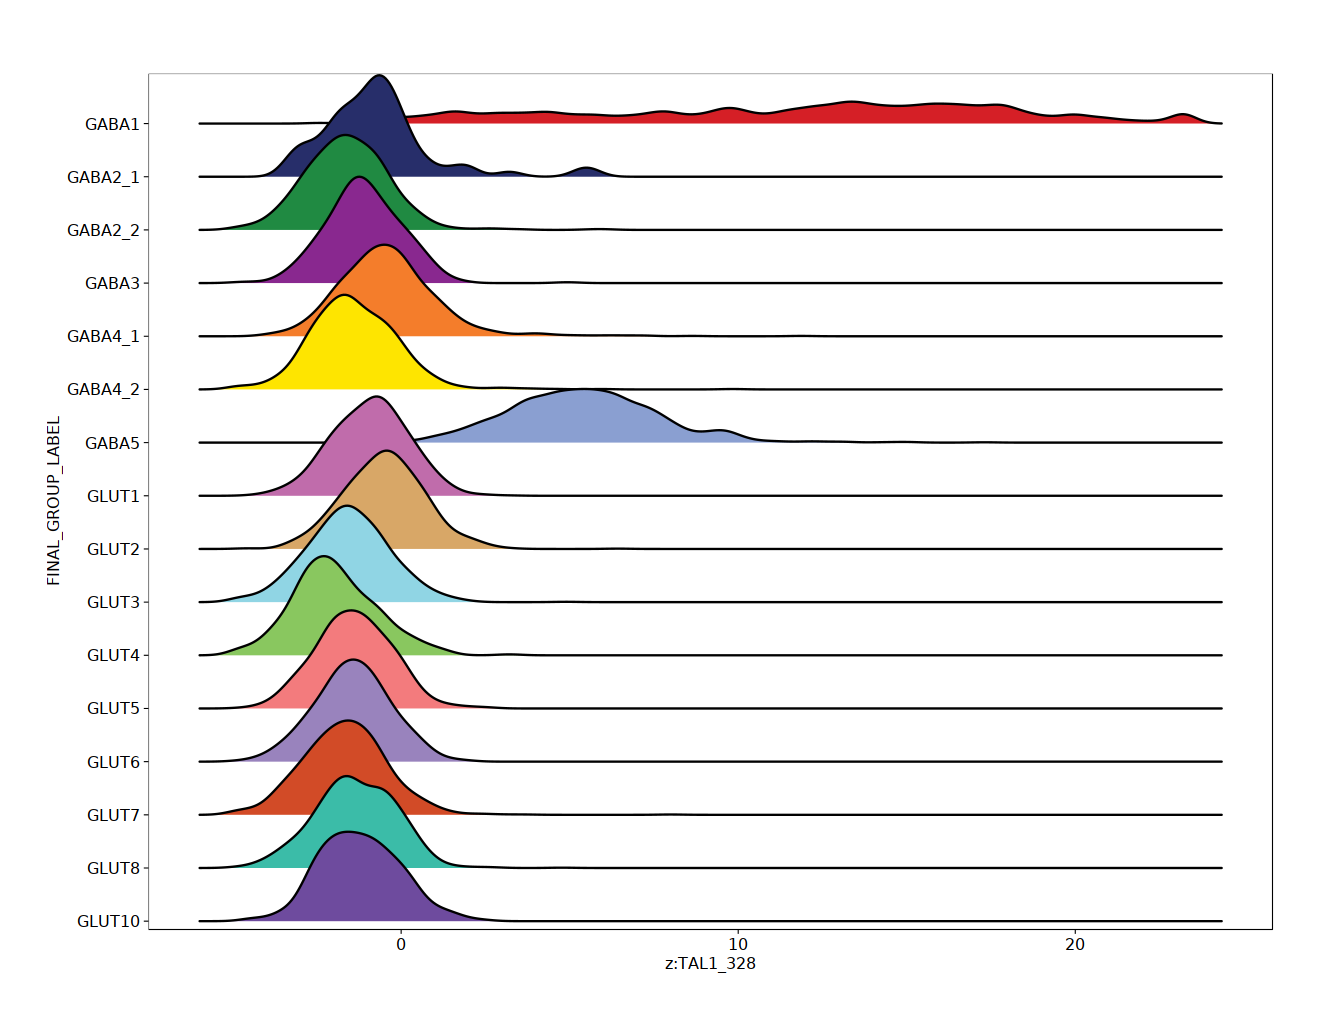

Picking joint bandwidth of 0.357

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


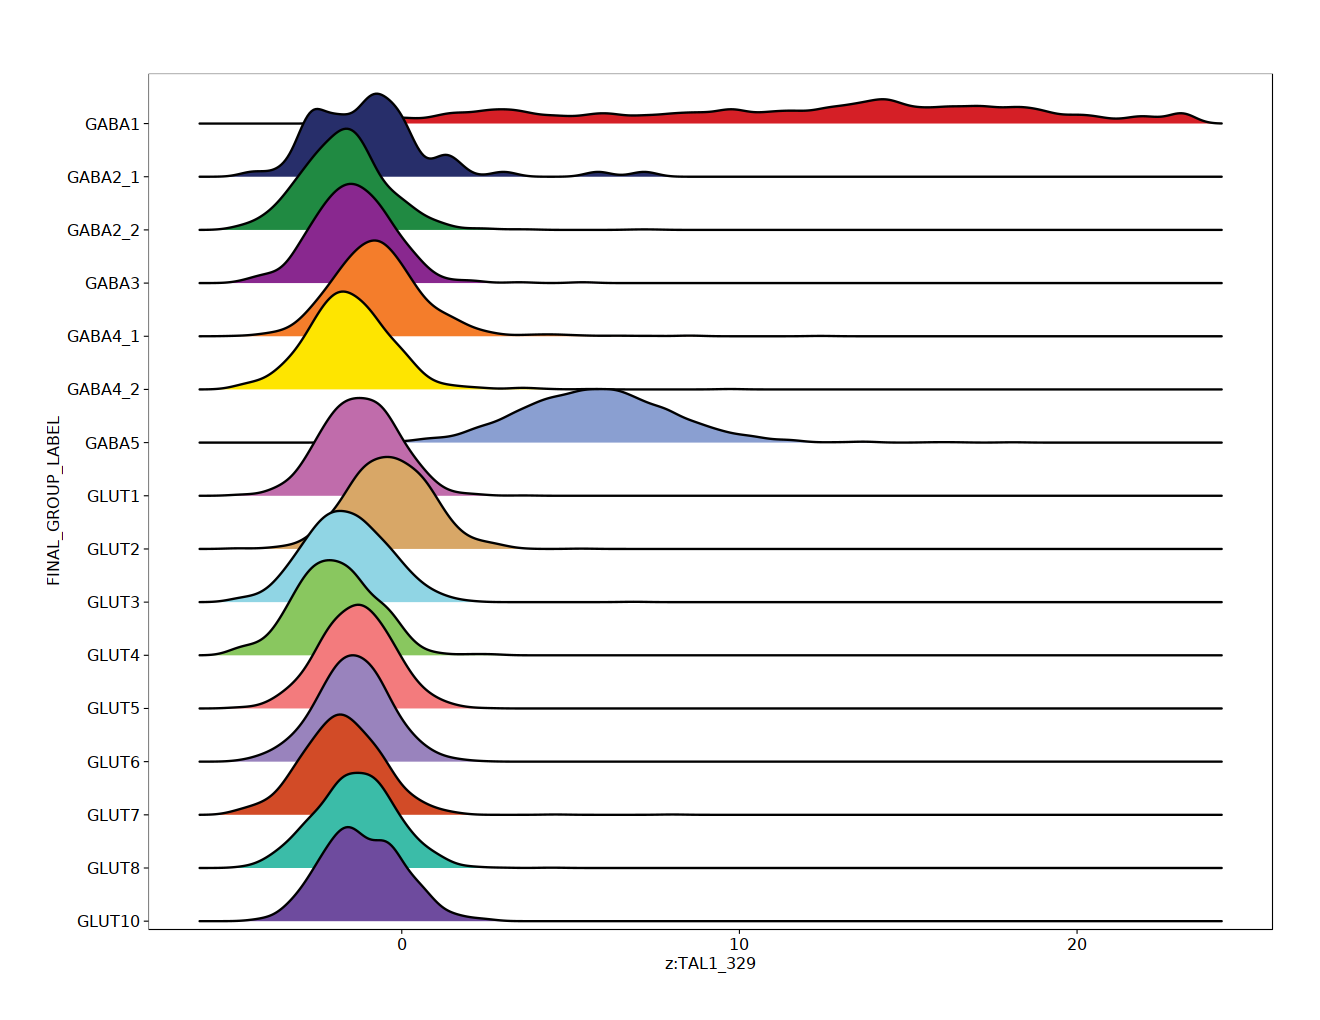

Picking joint bandwidth of 0.369

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


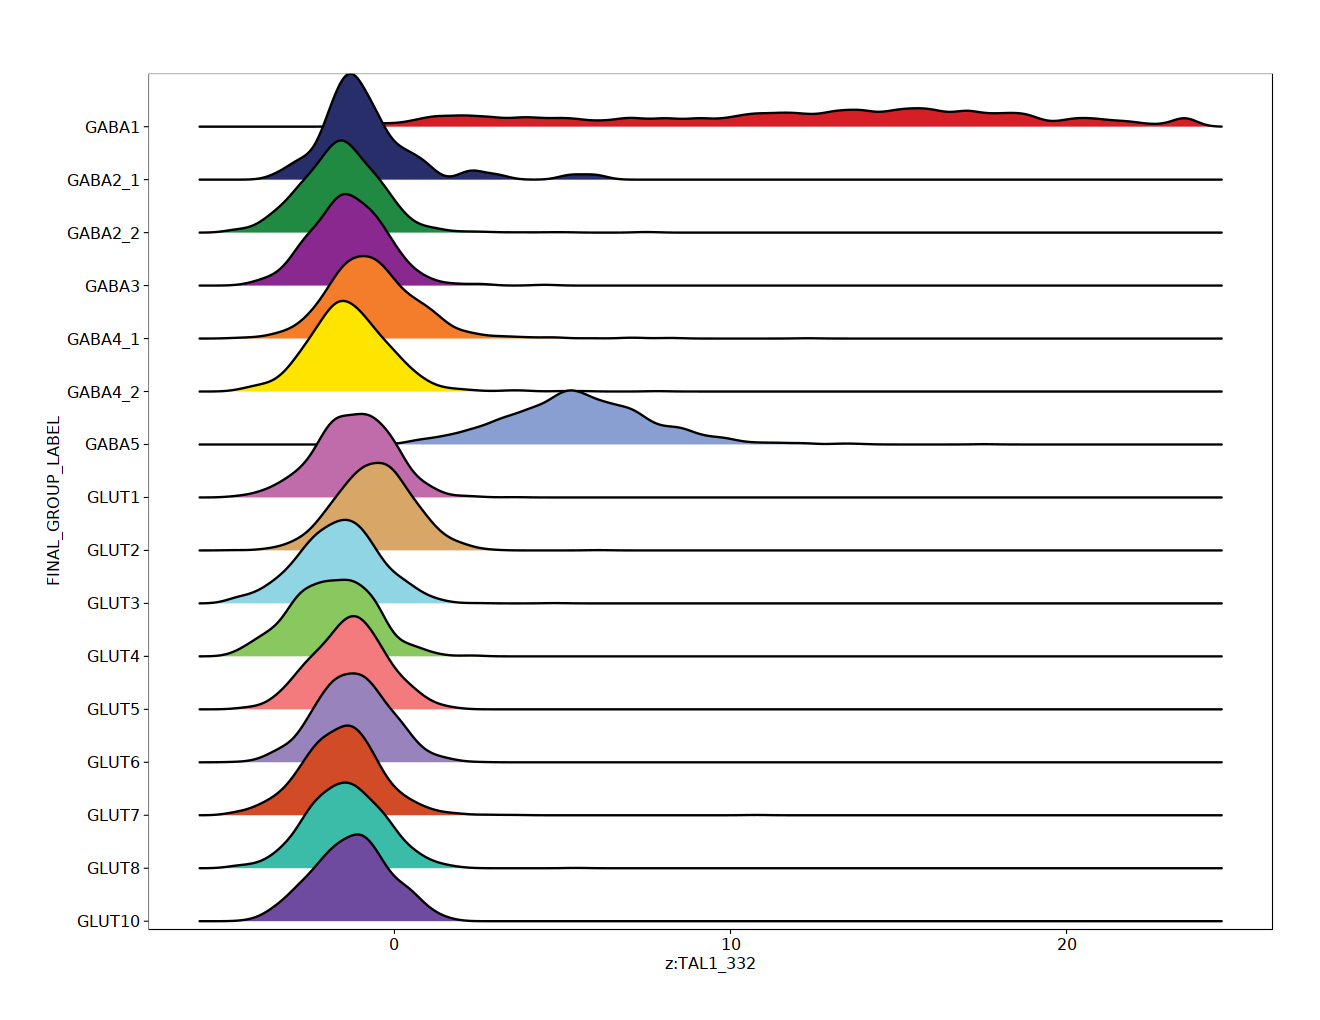

Picking joint bandwidth of 0.363

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


$`z:ASCL2_1553`

$`z:BATF_39`

$`z:HMGN3_124`

$`z:HOXB2_1776`

$`z:HOXB3_1777`

$`z:JDP2_1622`

$`z:JDP2_1624`

$`z:JDP2_1626`

$`z:LMX1B_1826`

$`z:MAFG_1629`

$`z:MEF2D_1404`

$`z:MXI1_47`

$`z:MYOD1_411`

$`z:NFE2_1637`

$`z:NFE2_310`

$`z:NFE2_8`

$`z:PAX7_1203`

$`z:PRRX2_1878`

$`z:TAL1_328`

$`z:TAL1_329`

$`z:TAL1_332`

$`z:TAL1_759`

$`z:TAL1_890`


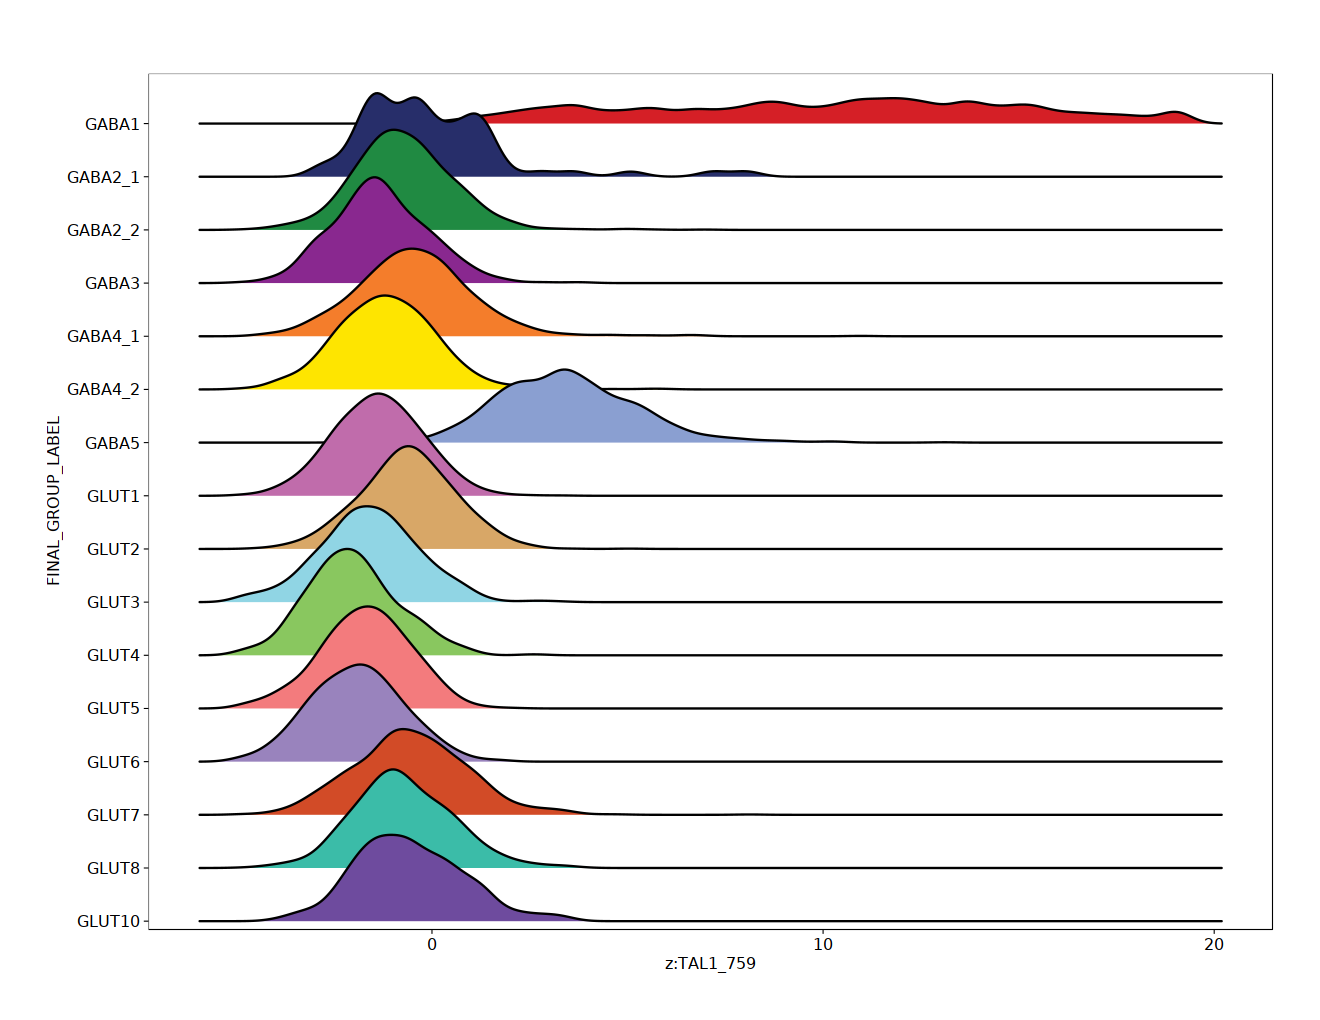

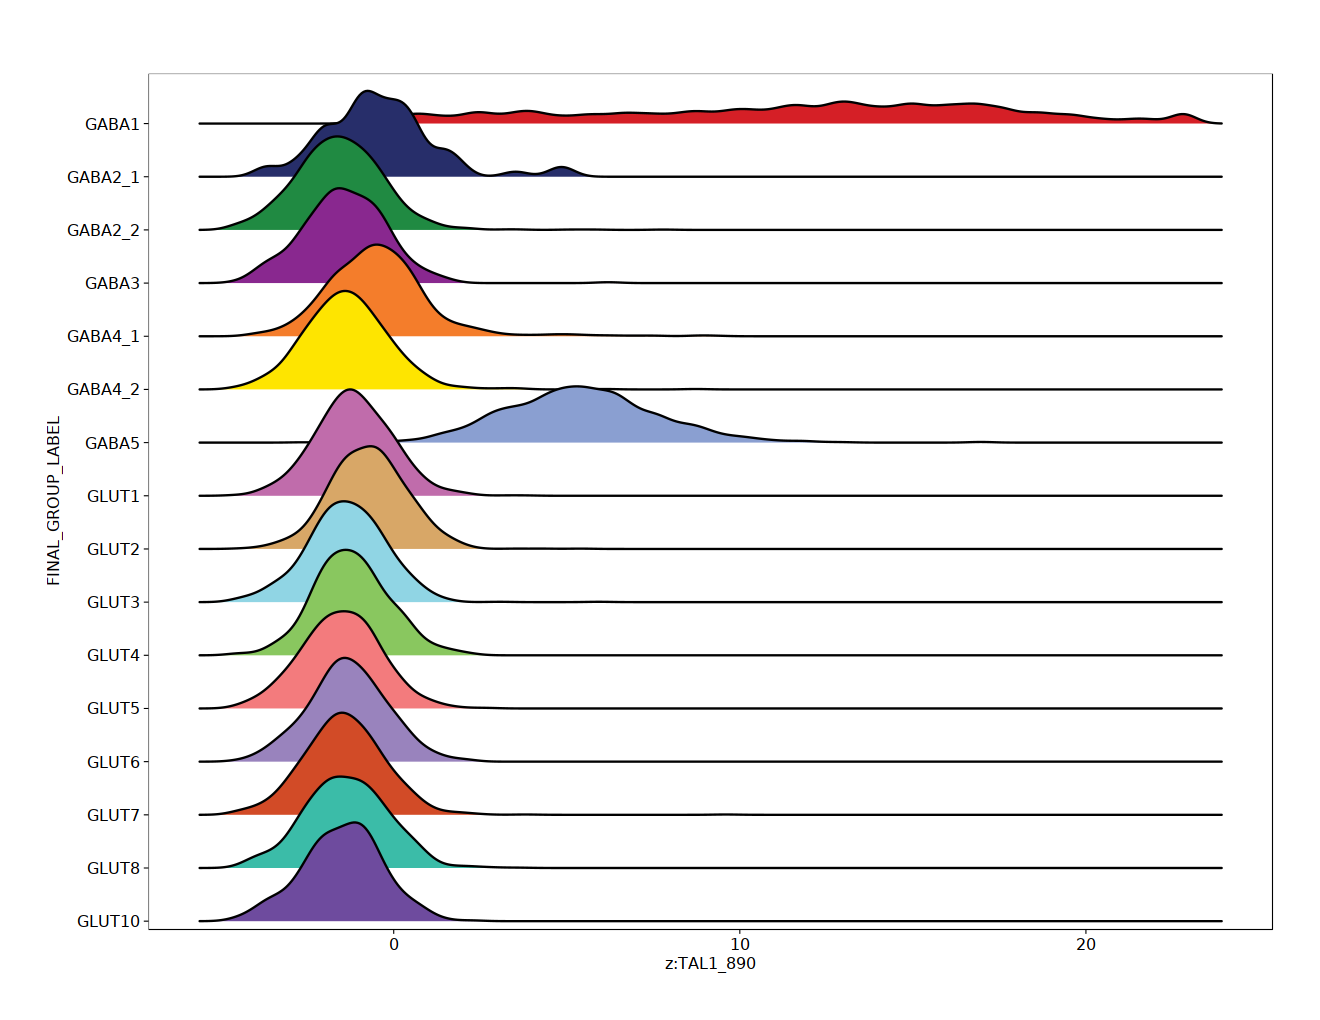

In [18]:
p_highDev <- plotGroups(ArchRProj = projNeuron, 
  groupBy = "FINAL_GROUP_LABEL", 
  colorBy = "MotifMatrix", 
  name = highDev_motifs_w_z,
  imputeWeights = getImputeWeights(projNeuron),
  baseSize = 9
)

In [ ]:
p_highDev

In [ ]:
p_mef2 <- plotGroups(ArchRProj = projNeuron, 
  groupBy = "FINAL_GROUP_LABEL", 
  colorBy = "MotifMatrix", 
  name = mef2_motifs_w_z,
  imputeWeights = getImputeWeights(projNeuron),
  baseSize = 9
)

p_mef2

In [19]:
# TF regulators, make data matrix
library(tidyr)
library(dplyr)

example = p[[1]]$data %>%
  # count number of rows for each combination
  group_by(x) %>%
summarise(avg = mean(y))


tf_data_mat = matrix(0, nrow(example), length(p))

for (ii in 1:length(p)){
    
    data_df = p[[ii]]$data %>%
  # count number of rows for each combination of server_id and protocol
  group_by(x) %>%
summarise(avg = mean(y))
    
    tf_data_mat[,ii] = data_df$avg
    
}

rownames(tf_data_mat) = example$x
colnames(tf_data_mat) = gsub('z:','',names(p))

library(reshape2)
library(hrbrthemes)
#melt(as.data.frame(tf_data_mat))
tf_data_df = as.data.frame(tf_data_mat)
tf_data_df$celltype = rownames(tf_data_mat)
tf_data_melted = melt(tf_data_df,id.vars='celltype')
colnames(tf_data_melted) = c('celltype', 'motif', 'z_score')


Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack


The following object is masked from ‘package:S4Vectors’:

    expand



Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:data.table’:

    between, first, last


The following object is masked from ‘package:matrixStats’:

    count


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The follo

In [20]:
# high dev, make data matrix
library(tidyr)
library(dplyr)

example = p_highDev[[1]]$data %>%
  # count number of rows for each combination
  group_by(x) %>%
summarise(avg = mean(y))


highDev_tf_data_mat = matrix(0, nrow(example), length(p_highDev))

for (ii in 1:length(p_highDev)){
    
    data_df = p_highDev[[ii]]$data %>%
  # count number of rows for each combination of server_id and protocol
  group_by(x) %>%
summarise(avg = mean(y))
    
    highDev_tf_data_mat[,ii] = data_df$avg
    
}

rownames(highDev_tf_data_mat) = example$x
colnames(highDev_tf_data_mat) = gsub('z:','',names(p_highDev))

library(reshape2)
library(hrbrthemes)
#melt(as.data.frame(tf_data_mat))
highDev_tf_data_df = as.data.frame(highDev_tf_data_mat)
highDev_tf_data_df$celltype = rownames(highDev_tf_data_mat)
highDev_tf_data_melted = melt(highDev_tf_data_df,id.vars='celltype')
colnames(highDev_tf_data_melted) = c('celltype', 'motif', 'z_score')

In [21]:
## add nicknames
nicknames = c('Exc-BNC2','Exc-NMUR2', 'Exc-NMU', 'Exc-TAC3','Exc-LMO3', 'Exc-SKOR2', 'Exc-MAF', 'Exc-MAFA', 
                  'Exc-SNTB1', 'Inh-CACNA2D3', 'Inh-SORCS1', 'Inh-PDZD2', 'Inh-NPY', 'Inh-MEF2C','Inh-NXPH1','Inh-PDYN')
ordered_gabaglut = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT10',
                     'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_1','GABA4_2','GABA5')
names(nicknames) = ordered_gabaglut

tf_data_melted$nickname = factor(nicknames[tf_data_melted$celltype], levels = nicknames)
table(tf_data_melted$nickname)

highDev_tf_data_melted$nickname = factor(nicknames[highDev_tf_data_melted$celltype], levels = nicknames)
table(highDev_tf_data_melted$nickname)


    Exc-BNC2    Exc-NMUR2      Exc-NMU     Exc-TAC3     Exc-LMO3    Exc-SKOR2 
          28           28           28           28           28           28 
     Exc-MAF     Exc-MAFA    Exc-SNTB1 Inh-CACNA2D3   Inh-SORCS1    Inh-PDZD2 
          28           28           28           28           28           28 
     Inh-NPY    Inh-MEF2C    Inh-NXPH1     Inh-PDYN 
          28           28           28           28 


    Exc-BNC2    Exc-NMUR2      Exc-NMU     Exc-TAC3     Exc-LMO3    Exc-SKOR2 
          23           23           23           23           23           23 
     Exc-MAF     Exc-MAFA    Exc-SNTB1 Inh-CACNA2D3   Inh-SORCS1    Inh-PDZD2 
          23           23           23           23           23           23 
     Inh-NPY    Inh-MEF2C    Inh-NXPH1     Inh-PDYN 
          23           23           23           23 

In [24]:
plot1<-ggplot(tf_data_melted, aes(nickname, motif, fill= z_score)) +
 geom_tile() + scale_fill_gradient(low="white", high="red") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + labs(x='Cell Type', y = 'Motif')

pdf(here(paste0("figures/exploratory/arokiaraj_paper/motifs/","motif_chromVarExpression_heatmap",Sys.Date(),".pdf")), width = 5, height = 4.5)
print(plot1)
dev.off()

png 
  2

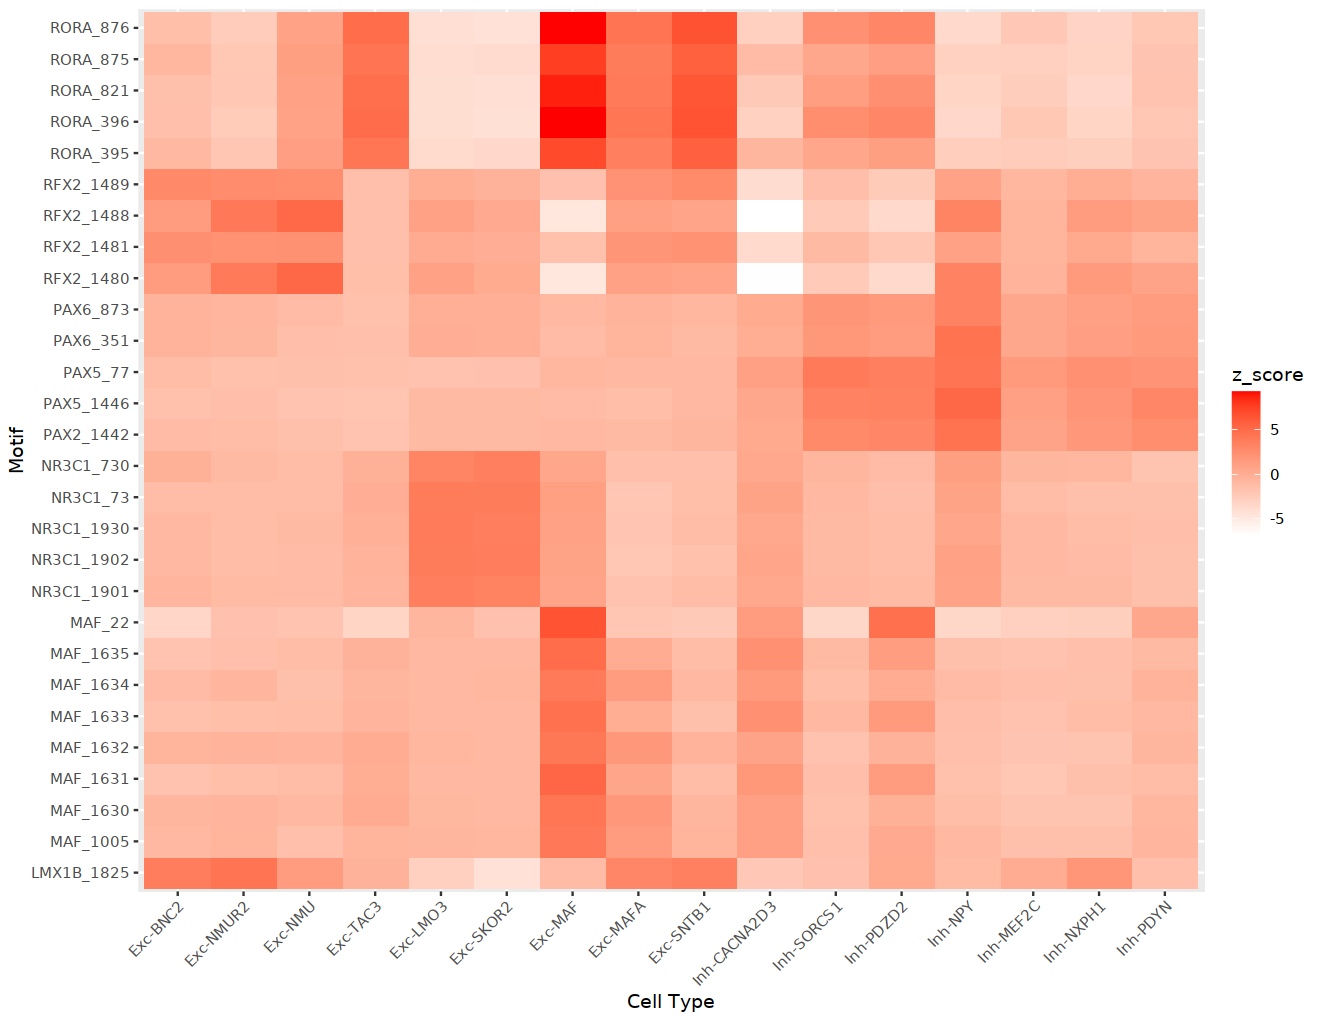

In [25]:
plot1

In [28]:
plot2<-ggplot(highDev_tf_data_melted, aes(nickname, motif, fill= z_score)) +
 geom_tile() + scale_fill_gradient(low="white", high="blue") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) + labs(x='Cell Type', y = 'Motif')

pdf(here(paste0("figures/exploratory/arokiaraj_paper/motifs/","motif_highDev_chromVarExpression_heatmap",Sys.Date(),".pdf")), width = 5, height = 4.5)
print(plot2)
dev.off()

png 
  2

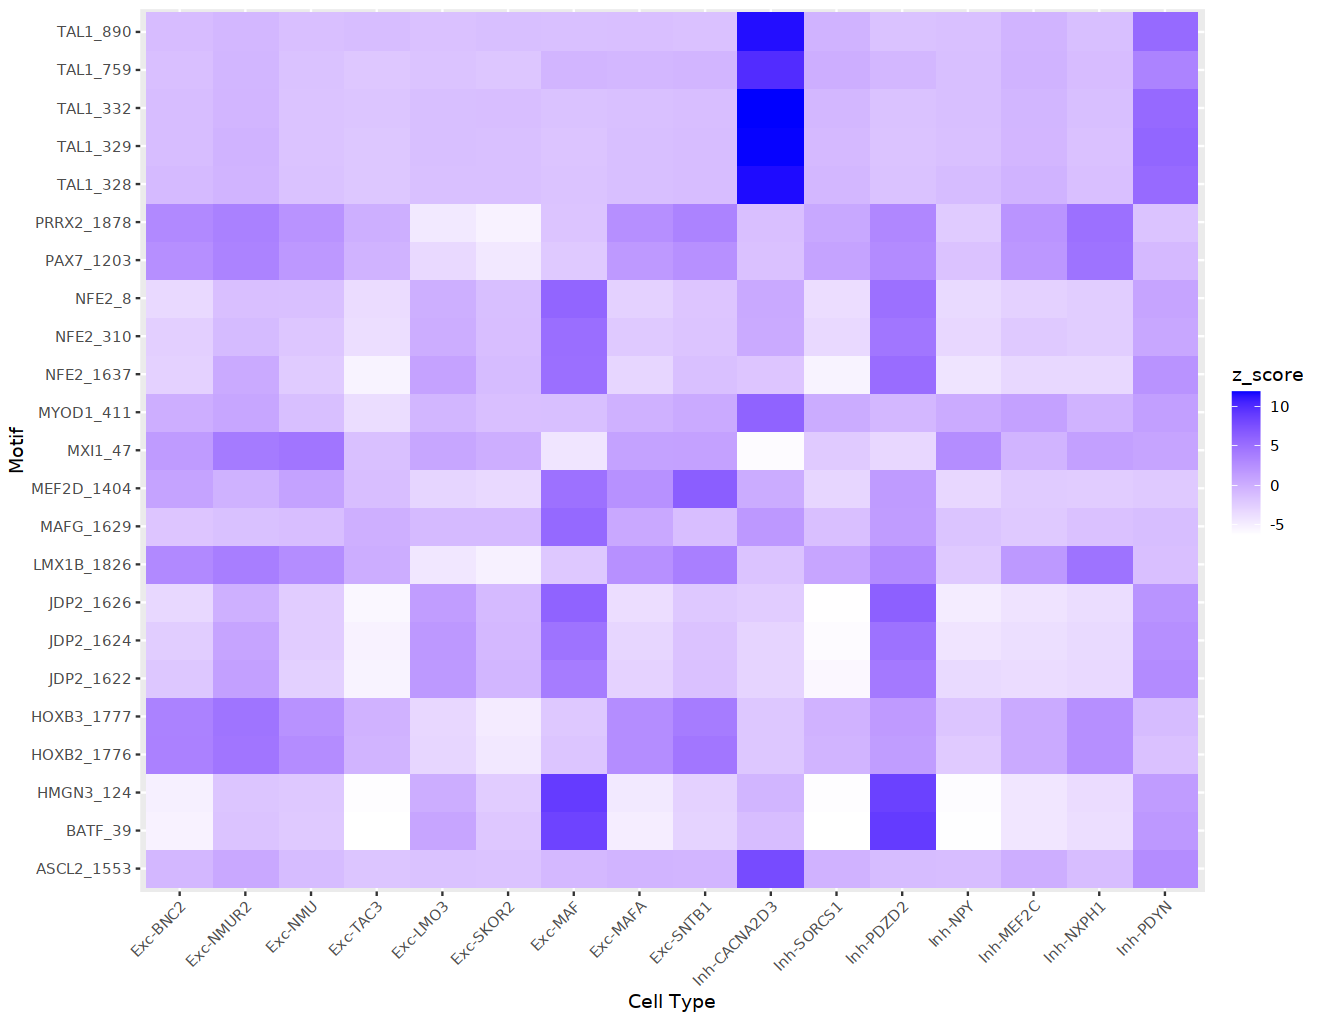

In [29]:
plot2

In [ ]:
for (ii in 1:length(p)){
    
    filename = paste0(here(),"/figures/exploratory/presentation_plots/3-14-23-lab_meeting/tf_deviations_", 
                      str_replace(names(p[ii]), 'z:', ''),'.pdf')
    pdf(file = filename,   # The directory you want to save the file in
    height = 6,
       width = 4) # The height of the plot in inches
    
    plot(p[[ii]])
    
    dev.off()
    
}

In [ ]:
for (ii in 1:length(q)){
    
    filename = paste0(here(),"/figures/exploratory/presentation_plots/3-14-23-lab_meeting/tf_deviations_embedding_", 
                      str_replace(names(p[ii]), 'z:', ''),'.pdf')
    pdf(file = filename,   # The directory you want to save the file in
    height = 6,
       width = 4) # The height of the plot in inches
    
    plot(q[[ii]])
    
    dev.off()
    
}

In [ ]:
q[[25]]

In [ ]:
p2 <- plotEmbedding(ArchRProj = projNeuron, colorBy = "cellColData", 
                    name = "FINAL_GROUP_LABEL", embedding = "UMAPX10", baseSize = 12)

filename = paste0(here(),"/figures/exploratory/presentation_plots/3-14-23-lab_meeting/embedding",'.pdf')

pdf(file = filename,   # The directory you want to save the file in
    height = 6,
       width = 4)


plot(p2)

dev.off()


In [ ]:
p2 <- lapply(seq_along(p), function(x){
  if(x != 1){
    p[[x]] + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6) +
    theme(plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")) +
    theme(
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank(),
        axis.title.y=element_blank()
    ) + ylab("")
  }else{
    p[[x]] + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6) +
    theme(plot.margin = unit(c(0.1, 0.1, 0.1, 0.1), "cm")) +
    theme(
        axis.ticks.y=element_blank(),
        axis.title.y=element_blank()
    ) + ylab("")
  }
})
do.call(cowplot::plot_grid, c(list(nrow = 1, rel_widths = c(2, rep(1, length(p2) - 1))),p2))

In [ ]:
q <- ggplot(data.frame(corGIM_MM), aes(cor, maxDelta, color = TFRegulator)) +
  geom_point() + 
  theme_ArchR() +
  geom_vline(xintercept = 0, lty = "dashed") + 
  scale_color_manual(values = c("NO"="darkgrey", "YES"="firebrick3")) +
  xlab("Correlation To Gene Score") +
  ylab("Max TF Motif Delta") +
  scale_y_continuous(
    expand = c(0,0), 
    limits = c(0, max(corGIM_MM$maxDelta)*1.05)
  )

q

In [ ]:
colnames(corGIM_MM)

In [ ]:
head(corGIM_MM)

In [ ]:
rowData(seZ)

In [ ]:
assay(seZ)[1:5,]